<a href="https://colab.research.google.com/github/minoxd/fiber_optic_box_inspection/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get dataset

In [ ]:
shutil.copytree(paths['dataset_dir'], local_paths['dataset_dir'], dirs_exist_ok=True)

PosixPath('/content/dataset_v2_ALL')

In [ ]:
with tarfile.open(paths['processed_dataset_compressed'], 'r:gz') as tar_file:
    tar_file.extractall(local_paths['dataset_dir'])
    print(f"Extracted {paths['processed_dataset_compressed']} to {local_paths['dataset_dir']}")

Extracted /content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL/processed_dataset.tar.gz to /content/dataset_v2_ALL


# Environmental Setup

## mount gdrive, import libraries, declare constants, specify paths

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from pathlib import Path
import shutil
import tarfile
import os
from sklearn.model_selection import train_test_split
import copy
from multiprocessing import Pool
import json
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from google.colab.patches import cv2_imshow
import pandas as pd

if Path('/content/sample_data').exists():
    shutil.rmtree('/content/sample_data')

In [3]:
IMGSZ = 960

These files are required in the `Data_INF` folder:
- data_label_All.tar.gz
- inf_raw_classes_v1.0.json
- matching_name_id_v1.0.xlsx

In [4]:
BASE_DIR = '/content/drive/MyDrive/fiber_optic_box_inspection'
if not Path(BASE_DIR).exists():
    raise FileNotFoundError(f'Base directory {BASE_DIR} not found. Check Google Drive mount.')

LOCAL_BASE_DIR = '/content'

paths = {
    'base_dir':                                   Path(BASE_DIR),
    'Data_INF':                                   Path(BASE_DIR, 'Data_INF'),
    'dataset_dir':                                Path(BASE_DIR, 'dataset_v2_ALL'),
    # 'yolo_output_dir':                            Path(BASE_DIR, 'runs_yolo'),
}

if not paths['dataset_dir'].exists():
    Path.mkdir(paths['dataset_dir'])

paths['raw_classes'] =                            Path(paths['Data_INF'], 'inf_raw_classes_v1.0.json')
paths['new_raw_classes'] =                        Path(paths['Data_INF'], 'inf_raw_classes_v1.0_new.json')
paths['matching_name_id'] =                       Path(paths['Data_INF'], 'matching_name_id_v1.0.xlsx')
paths['dataset_compressed'] =                     Path(paths['Data_INF'], 'data_label_ALL.tar.gz')

paths['processed_dataset_compressed'] =           Path(paths['dataset_dir'], 'processed_dataset.tar.gz')

local_paths = {
    'base_dir':                                   Path(LOCAL_BASE_DIR),
    'dataset_dir':                                Path(LOCAL_BASE_DIR, 'dataset_v2_ALL'),
}

if not local_paths['dataset_dir'].exists():
    Path.mkdir(local_paths['dataset_dir'])

local_paths['image_label_dir'] =                  Path(local_paths['dataset_dir'], 'image_label')
local_paths['label_bbox_backup_dir'] =            Path(local_paths['dataset_dir'], 'label_bbox_backup')
local_paths['label_id_backup_dir'] =              Path(local_paths['dataset_dir'], 'label_id_backup')
local_paths['ids_from_label_files'] =             Path(local_paths['dataset_dir'], 'ids_from_label_files_backup_dir.txt')
local_paths['processed_dataset_compressed'] =     Path(local_paths['dataset_dir'], 'processed_dataset.tar.gz')

# local_paths['yolo_data_cfg'] =                    Path(local_paths['dataset_dir'], 'yolo_data_cfg.yaml')
# local_paths['train_paths'] =                      Path(local_paths['dataset_dir'], 'train.txt')
# local_paths['val_paths'] =                        Path(local_paths['dataset_dir'], 'val.txt')
# local_paths['test_paths'] =                       Path(local_paths['dataset_dir'], 'test.txt')


### percentile process paths

In [5]:
#P00
local_paths['image_label_P00_dir'] =              Path(local_paths['dataset_dir'], 'image_label_P00')
local_paths['empty_data_P00_dir'] =               Path(local_paths['dataset_dir'], 'empty_data_P00')
local_paths['label_id_backup_P00_dir'] =          Path(local_paths['dataset_dir'], 'label_id_backup_P00')
local_paths['class_names_P00'] =                  Path(local_paths['dataset_dir'], 'class_names_P00.txt')
local_paths['all_paths_P00'] =                    Path(local_paths['dataset_dir'], 'all_P00.txt')
local_paths['train_paths_P00'] =                  Path(local_paths['dataset_dir'], 'train_P00.txt')
local_paths['val_paths_P00'] =                    Path(local_paths['dataset_dir'], 'val_P00.txt')
local_paths['test_paths_P00'] =                   Path(local_paths['dataset_dir'], 'test_P00.txt')
#P25
local_paths['image_label_P25_dir'] =              Path(local_paths['dataset_dir'], 'image_label_P25')
local_paths['empty_data_P25_dir'] =               Path(local_paths['dataset_dir'], 'empty_data_P25')
local_paths['label_id_backup_P25_dir'] =          Path(local_paths['dataset_dir'], 'label_id_backup_P25')
local_paths['class_names_P25'] =                  Path(local_paths['dataset_dir'], 'class_names_P25.txt')
local_paths['all_paths_P25'] =                    Path(local_paths['dataset_dir'], 'all_P25.txt')
local_paths['train_paths_P25'] =                  Path(local_paths['dataset_dir'], 'train_P25.txt')
local_paths['val_paths_P25'] =                    Path(local_paths['dataset_dir'], 'val_P25.txt')
local_paths['test_paths_P25'] =                   Path(local_paths['dataset_dir'], 'test_P25.txt')
#P30
local_paths['image_label_P30_dir'] =              Path(local_paths['dataset_dir'], 'image_label_P30')
local_paths['empty_data_P30_dir'] =               Path(local_paths['dataset_dir'], 'empty_data_P30')
local_paths['label_id_backup_P30_dir'] =          Path(local_paths['dataset_dir'], 'label_id_backup_P30')
local_paths['class_names_P30'] =                  Path(local_paths['dataset_dir'], 'class_names_P30.txt')
local_paths['all_paths_P30'] =                    Path(local_paths['dataset_dir'], 'all_P30.txt')
local_paths['train_paths_P30'] =                  Path(local_paths['dataset_dir'], 'train_P30.txt')
local_paths['val_paths_P30'] =                    Path(local_paths['dataset_dir'], 'val_P30.txt')
local_paths['test_paths_P30'] =                   Path(local_paths['dataset_dir'], 'test_P30.txt')
#P35
local_paths['image_label_P35_dir'] =              Path(local_paths['dataset_dir'], 'image_label_P35')
local_paths['empty_data_P35_dir'] =               Path(local_paths['dataset_dir'], 'empty_data_P35')
local_paths['label_id_backup_P35_dir'] =          Path(local_paths['dataset_dir'], 'label_id_backup_P35')
local_paths['class_names_P35'] =                  Path(local_paths['dataset_dir'], 'class_names_P35.txt')
local_paths['all_paths_P35'] =                    Path(local_paths['dataset_dir'], 'all_P35.txt')
local_paths['train_paths_P35'] =                  Path(local_paths['dataset_dir'], 'train_P35.txt')
local_paths['val_paths_P35'] =                    Path(local_paths['dataset_dir'], 'val_P35.txt')
local_paths['test_paths_P35'] =                   Path(local_paths['dataset_dir'], 'test_P35.txt')
#P40
local_paths['image_label_P40_dir'] =              Path(local_paths['dataset_dir'], 'image_label_P40')
local_paths['empty_data_P40_dir'] =               Path(local_paths['dataset_dir'], 'empty_data_P40')
local_paths['label_id_backup_P40_dir'] =          Path(local_paths['dataset_dir'], 'label_id_backup_P40')
local_paths['class_names_P40'] =                  Path(local_paths['dataset_dir'], 'class_names_P40.txt')
local_paths['all_paths_P40'] =                    Path(local_paths['dataset_dir'], 'all_P40.txt')
local_paths['train_paths_P40'] =                  Path(local_paths['dataset_dir'], 'train_P40.txt')
local_paths['val_paths_P40'] =                    Path(local_paths['dataset_dir'], 'val_P40.txt')
local_paths['test_paths_P40'] =                   Path(local_paths['dataset_dir'], 'test_P40.txt')

## utils

In [6]:
def write_image_paths(paths, destination):
    with open(destination, 'w') as f:
        for path in paths:
            f.write(f'{path}\n')

In [7]:
def read_image_paths(file_path):
    if Path(file_path).exists():
        with open(file_path, 'r') as f:
            return [Path(line.strip()) for line in f if line.strip()]
    return []

In [8]:
def read_class_names(path: Path):
    with open(path, 'r') as f:
        class_names = [name.strip() for name in f.readlines()]
    return class_names

In [9]:
def investigate_set(image_paths: Path, cls_ids):
    class_instance_dict = {i: [[], 0] for i in cls_ids}
    empty_label_list = []

    with open(image_paths, 'r') as f:
        paths = [path.strip() for path in f.readlines()]

    for path in paths:
        path = Path(path)
        image_id = path.stem
        with open(path.with_suffix('.txt'), 'r') as f:
            lines = f.readlines()

        if len(lines) == 0:
            empty_label_list.append(image_id)
            continue

        dictt = {}
        for line in lines:
            class_id = int(line.strip().split(' ')[0])
            if class_id not in dictt:
                dictt[class_id] = 0
            dictt[class_id] += 1

        for k, v in dictt.items():
            class_instance_dict[k][0].append(image_id)
            class_instance_dict[k][1] += v
    return class_instance_dict, empty_label_list

In [10]:
def investigation_dict2df(investigate: dict):
    df_investigate = pd.DataFrame(
        data={k: [k, new_class_dict[str(k)], len(v[0]), v[1]] for k, v in investigate.items()}
    ).transpose().rename(columns={0: 'class_id', 1: 'class_name', 2: '# images', 3: '# instances'})
    print(len(df_investigate))
    df_investigate.sample(5)
    return df_investigate

# Data Preparation (Run once per lifetime)

## Extract compressed dataset to VM

The compressed dataset is located on GDrive. We extract the file directly from GDrive to VM's storage

In [11]:
if not Path(local_paths['image_label_dir']).exists():
    Path.mkdir(local_paths['image_label_dir'])
shutil.rmtree(local_paths['image_label_dir'])

In [12]:
with tarfile.open(paths['dataset_compressed'], 'r:gz') as tar_file:
    tar_file.extractall(local_paths['dataset_dir'])
print(f"Extracted {paths['dataset_compressed']} to {local_paths['dataset_dir']}")

Extracted /content/drive/MyDrive/fiber_optic_box_inspection/Data_INF/data_label_ALL.tar.gz to /content/dataset_v2_ALL


In [13]:
p_old = Path(local_paths['dataset_dir'], 'data_label_v2_ALL')
p_new = Path(local_paths['image_label_dir'])
p_old.rename(p_new)
print(f"Renamed {p_old} to {p_new}")

Renamed /content/dataset_v2_ALL/data_label_v2_ALL to /content/dataset_v2_ALL/image_label


In [14]:
for root, dirs, files in os.walk(local_paths['image_label_dir']):
    print(f"Total image and label files: {len(files)}")

Total image and label files: 22452


## Inspect class ids from label files and json
After this step, set of class ids from label files and set of class ids from json are the same (139 classes in total)

todo: functions in this section serve too many purposes, should refactor

### check bbox rounding error in label files

In [15]:
def check_label_file(args):
    label_file, backup_dir = args
    filename = label_file.name
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()

        new_lines = copy.deepcopy(lines)
        indexes_of_change = set()
        for idx, line in enumerate(lines):
            parts = line.strip().split(' ')
            class_id = int(parts[0])
            (x_center, y_center, width, height) = map(float, parts[1:5])
            x_min, y_min, x_max, y_max = x_center - width/2, y_center - height/2, x_center + width/2, y_center + height/2
            new_x_center, new_y_center = x_center, y_center
            if x_min < 0.0:
                new_x_center = 0.0 + width/2
                indexes_of_change.add(idx)
            if y_min < 0.0:
                new_y_center = 0.0 + height/2
                indexes_of_change.add(idx)
            if x_max > 1.0:
                new_x_center = 1.0 - width/2
                indexes_of_change.add(idx)
            if y_max > 1.0:
                new_y_center = 1.0 - height/2
                indexes_of_change.add(idx)
            new_lines[idx] = f'{class_id} {new_x_center} {new_y_center} {width} {height}\n'

        if len(indexes_of_change) == 0:
            return

        backup_file = Path(backup_dir, filename)
        shutil.copy2(label_file, backup_file)
        with open(label_file, 'w') as f:
            f.writelines(new_lines)

        def show_changes(indexes, ls, new_ls):
            str_from = ''
            str_to = ''
            for idx in indexes:
                str_from += f'{ls[idx]}\n'
            for idx in indexes:
                str_to += f'{new_ls[idx]}\n'
            return f'from\n{str_from}to\n{str_to}'

        return f'Processed {filename}:\n{show_changes(indexes_of_change, lines, new_lines)}'
    except Exception as e:
        return f'Error processing {filename}: {e}'

def check_label_files(label_dir, backup_dir):

    all_labels = [Path(label_dir, f) for f in Path.iterdir(label_dir) if f.suffix == '.txt']

    args = [(f, backup_dir) for f in all_labels]

    with Pool() as pool:
        results = pool.map(check_label_file, args)

    for result in results:
        if result:
            print(result)

    return len(all_labels)

In [16]:
if not Path(local_paths['label_bbox_backup_dir']).exists():
    Path.mkdir(local_paths['label_bbox_backup_dir'])

num_files_checked = check_label_files(
    label_dir=local_paths['image_label_dir'],
    backup_dir=local_paths['label_bbox_backup_dir'],
)

Processed 2022_10_28_16_35_21-BTNP005155HO.txt:
from
137 0.38703703703703696 0.4362015751383568 0.774074074074074 0.7657407407407407

to
137 0.387037037037037 0.4362015751383568 0.774074074074074 0.7657407407407407


Processed 2022_11_08_11_21_34-QNHP103258HO.txt:
from
73 0.587037037037037 0.4888888888888889 0.9592592592592593 0.7944444444444444

to
73 0.5203703703703704 0.4888888888888889 0.9592592592592593 0.7944444444444444


Processed 2022_11_08_09_56_54-HNIP446147HO.txt:
from
34 0.5399505766062604 0.8109530261969287 0.9200988467874794 0.055239385727190574

to
34 0.5399505766062602 0.8109530261969287 0.9200988467874794 0.055239385727190574


Processed 2022_12_08_16_10_56-HYNP002105HO.txt:
from
73 0.5173974741024551 0.5890698169433802 0.9652050517950902 0.8185185185185186

to
73 0.517397474102455 0.5890698169433802 0.9652050517950902 0.8185185185185186


Processed 2022_11_11_15_52_19-BTEP015147HO.txt:
from
137 0.5216191287072514 0.48101851851851846 0.9567617425854973 0.9620370370370

In [17]:
print(f'Total files checked: {num_files_checked}')

Total files checked: 11226


### Get class ids from json

In [18]:
with open(paths['raw_classes'], 'r') as f:
    class_dict = json.load(f)
print('Class dictionary from JSON:', class_dict)

class_ids_from_json = set(sorted([int(k) for k in class_dict.keys()]))

Class dictionary from JSON: {'0': '1.0', '1': '1.1', '2': '1.2', '4': '1.7', '7': '2.0', '8': '2.1', '9': '2.3', '10': '3.0', '11': '3.1', '12': '4.0', '13': '4.1', '14': '5.0', '15': '5.1', '16': '6.0', '17': '6.1', '18': '7.0', '19': '7.1', '20': '7.2', '21': '7.3', '23': '7.7', '24': '8.0', '25': '8.3', '27': '8.5', '28': '9.0', '30': '9.4', '32': '10.0', '33': '10.1', '34': '11.0', '35': '11.1', '36': '13.0', '37': '13.1', '38': '13.2', '41': '14.0', '42': '14.1', '43': '14.2', '44': '14.3', '45': '15.0', '46': '15.1', '47': '15.4', '50': '17.0', '51': '17.1', '52': '18.0', '53': '18.1', '54': '19.0', '55': '19.1', '56': '19.2', '57': '19.3', '58': '19.4', '59': '19.5', '60': '20.0', '61': '20.1', '62': '20.2', '63': '20.3', '67': '23.0', '68': '23.1', '69': '23.2', '70': '24.0', '71': '24.1', '72': '24.3', '73': '26.0', '74': '26.1', '75': '27.0', '76': '27.1', '77': '28.0', '78': '28.3', '80': '29.0', '81': '29.1', '82': '29.2', '83': '29.4', '84': '30.0', '85': '30.1', '86': '32

### Backup ids from label files before removal

In [19]:
def get_class_ids_from_label_file(label_file):
    class_ids = set()
    msg = None
    try:
        ids = set()
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    id = line.strip().split()[0]
                    ids.add(id)
        msg = f'Ids in {label_file}: {ids}'
        class_ids.update(ids)
    except Exception as e:
        msg = f'Error processing {label_file}: {e}'
    return class_ids, msg

def get_class_ids_from_label_files(label_dir):
    label_files = [Path(label_dir, f) for f in Path.iterdir(label_dir) if f.suffix == '.txt']
    with Pool() as pool:
        results = pool.map(get_class_ids_from_label_file, label_files)
    class_ids, msgs = zip(*results)
    class_ids = set().union(*class_ids)

    with open(local_paths['ids_from_label_files'], 'w') as f:
        f.write(str(len(msgs)) + '\n')
        for msg in msgs:
            f.write(f'{msg}\n')

    return set(sorted([int(id) for id in class_ids]))

In [20]:
class_ids_from_label_files = get_class_ids_from_label_files(local_paths['image_label_dir'])

### Get class ids differences

In [21]:
class_ids = class_ids_from_json & class_ids_from_label_files
class_ids_from_label_files_not_in_json = class_ids_from_label_files - class_ids
class_ids_from_json_not_in_label_files = class_ids_from_json - class_ids

In [22]:
print(f'Class IDs from json (count: {len(class_ids_from_json)}):                                          \n\t {class_ids_from_json}')
print(f'Class IDs from label files (count: {len(class_ids_from_label_files)}):                            \n\t {class_ids_from_label_files}')
print(f'Class Ids from label files but not in json (count: {len(class_ids_from_label_files_not_in_json)}):\n\t {class_ids_from_label_files_not_in_json}')
print(f'Class Ids from json but not in label files (count: {len(class_ids_from_json_not_in_label_files)}):\n\t {class_ids_from_json_not_in_label_files}')
print(f'Class Ids (count: {len(class_ids)}):                                                              \n\t {class_ids}')

Class IDs from json (count: 151):                                          
	 {0, 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172}
Class IDs from label files (count: 150):                            
	 {0, 1, 2, 3, 4, 7, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 54, 55, 56, 57, 58, 60, 61, 62, 63,

### From label files, remove labels that their ids does not appear in json

In [23]:
def process_label_file(args):
    label_file, backup_dir, class_ids_to_remove = args
    label_file = Path(label_file)
    filename = label_file.name
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()

        lines_kept = [
            line for line in lines
            if line.strip() and line.strip().split()[0] not in class_ids_to_remove
        ]

        lines_removed = len(lines) - len(lines_kept)

        if lines_removed <= 0:
            return

        backup_file = Path(backup_dir, filename)
        shutil.copy2(label_file, backup_file)
        with open(label_file, 'w') as f:
            f.writelines(lines_kept)

        return f'Processed {filename}: {lines_removed} lines removed, original backed up'
    except Exception as e:
        return f'Error processing {filename}: {e}'

def process_label_files(label_dir, backup_dir, class_ids_to_remove):
    class_ids_to_remove = [str(id) for id in class_ids_to_remove]

    all_labels = [Path(label_dir, f) for f in Path.iterdir(label_dir) if f.suffix == '.txt']

    args = [(f, backup_dir, class_ids_to_remove) for f in all_labels]

    with Pool() as pool:
        results = pool.map(process_label_file, args)

    for result in results:
        if result:
            print(result)

    return len(all_labels)

In [24]:
if not Path(local_paths['label_id_backup_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_dir'],
    backup_dir=local_paths['label_id_backup_dir'],
    class_ids_to_remove=class_ids_from_label_files_not_in_json
)

Processed 2022_11_14_13_38_23-BLUP009251HO.txt: 1 lines removed, original backed up
Processed 2022_11_17_15_35_56-HGGP017481HO.txt: 1 lines removed, original backed up
Processed 2022_11_13_10_30_08-CTOP036426HO.txt: 1 lines removed, original backed up
Processed 2022_11_07_15_24_22-DTPP007173HO.txt: 1 lines removed, original backed up
Processed 2022_11_10_09_54_28-AGGP054258HO.txt: 1 lines removed, original backed up
Processed 2022_11_09_10_43_31-STGP030095HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_15_36_36-BRUP040352HO.txt: 2 lines removed, original backed up
Processed 2022_11_03_10_18_25-DLKP035064HO.txt: 1 lines removed, original backed up
Processed 2022_10_28_11_26_37-AGGP045339HO.txt: 1 lines removed, original backed up
Processed 2022_11_07_13_02_42-STGP029059HO.txt: 1 lines removed, original backed up
Processed 2022_11_15_10_50_52-AGGP052178HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_15_56_10-STGP028308HO.txt: 1 lines removed, original ba

In [25]:
print(f'Total files processed: {num_files_processed}')

Total files processed: 11226


### From json, remove ids that are not in label files, then save to a new json

In [26]:
with open(paths['raw_classes'], 'r') as f:
    new_class_dict = json.load(f)

for id in class_ids_from_json_not_in_label_files:
    new_class_dict.pop(str(id))
try:
    with open(paths['new_raw_classes'], 'w') as f:
        json.dump(new_class_dict, f, indent=2)
    print(f"JSON file created: {paths['new_raw_classes']}")
except Exception as e:
    print(f'Error writing JSON file: {e}')

JSON file created: /content/drive/MyDrive/fiber_optic_box_inspection/Data_INF/inf_raw_classes_v1.0_new.json


# drop P00

In [27]:
shutil.copytree(local_paths['image_label_dir'], local_paths['image_label_P00_dir'])

PosixPath('/content/dataset_v2_ALL/image_label_P00')

## investigate dataset

In [28]:
#before remove
all_images_P00 = sorted([Path(local_paths['image_label_P00_dir'], f) for f in Path.iterdir(local_paths['image_label_P00_dir']) if f.suffix == '.jpg'])
print(len(all_images_P00))
write_image_paths(all_images_P00, local_paths['all_paths_P00'])

11226


In [29]:
class_ids_P00 = class_ids.copy()
investigate_all_P00, empty_label_list_P00 = investigate_set(local_paths['all_paths_P00'], class_ids_P00)
print(len(investigate_all_P00))
print(f'after investigation, there are {len(empty_label_list_P00)} data with no labels')

139
after investigation, there are 670 data with no labels


In [30]:
if not Path(local_paths['empty_data_P00_dir']).exists():
    Path.mkdir(local_paths['empty_data_P00_dir'])
count = 0
for image_id in empty_label_list_P00:
    shutil.move(Path(local_paths['image_label_P00_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P00_dir'])
    shutil.move(Path(local_paths['image_label_P00_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P00_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 1340


In [31]:
df_investigate_all_P00 = investigation_dict2df(investigate_all_P00)

139


In [32]:
df_investigate_all_P00.to_csv('/content/dataset_v2_ALL/investigate_all_P00.csv')

In [33]:
percentiles_image = np.percentile(df_investigate_all_P00['# images'], [25, 30, 35, 40, 45, 50])
print(percentiles_image)

percentiles_instance = np.percentile(df_investigate_all_P00['# instances'], [25, 30, 35, 40, 45, 50])
print(percentiles_instance)

[21.0 40.4 57.3 95.0 148.8 208.0]
[26.5 42.199999999999996 69.3 102.4 159.3 219.0]


/tmp/ipython-input-34-2777170904.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all_P00 \


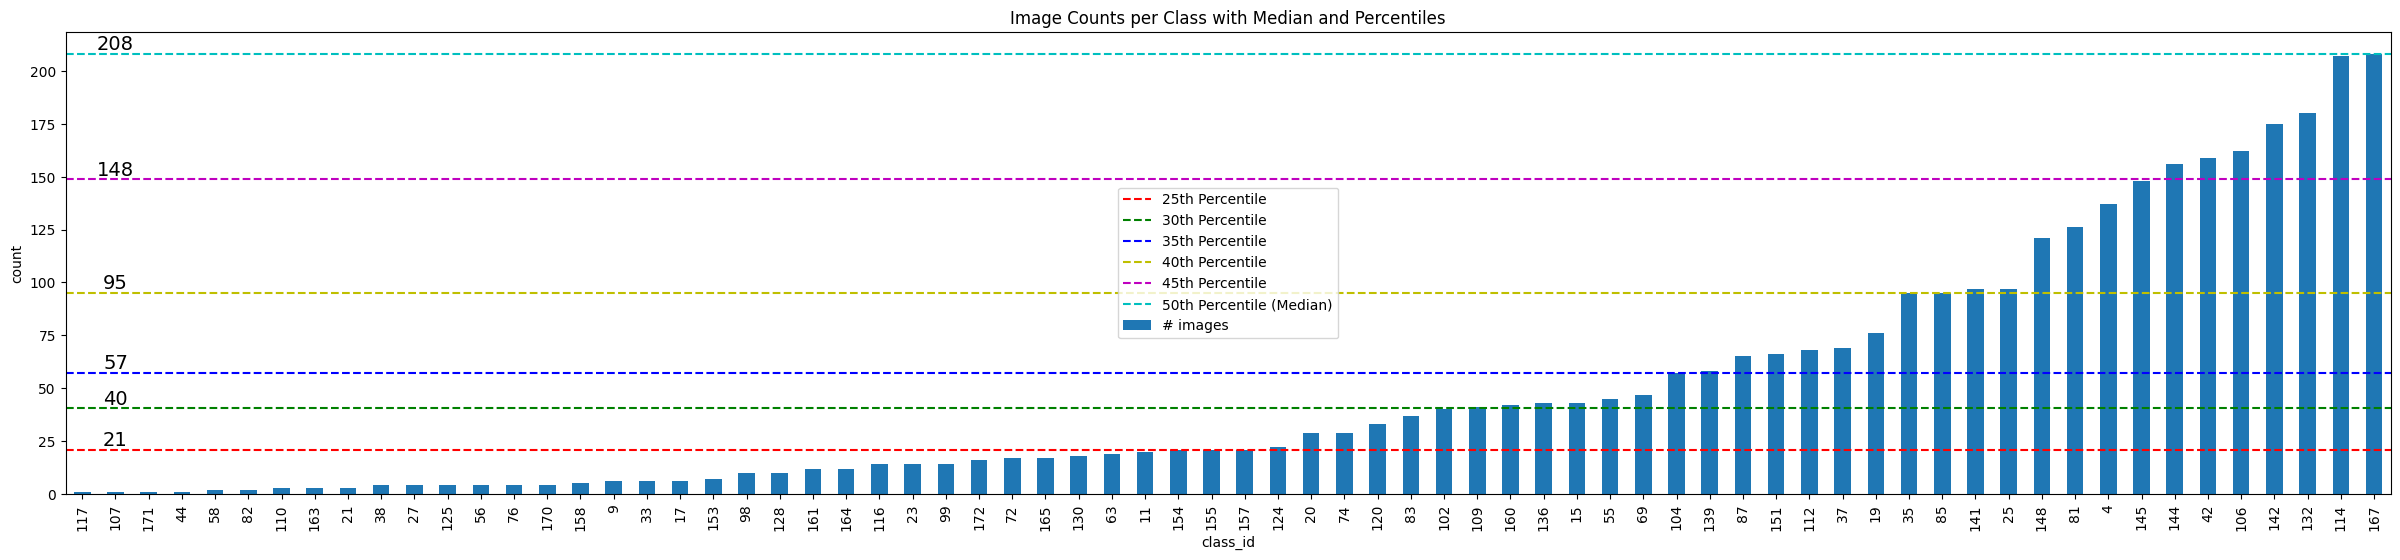

In [34]:
df_investigate_all_P00 \
    .sort_values(by='# images')[(df_investigate_all_P00['# images'] <= percentiles_image[5])] \
    .plot.bar(y=['# images'], figsize=(30,6))
plt.axhline(y=percentiles_image[0], color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=percentiles_image[1], color='g', linestyle='--', label='30th Percentile')
plt.axhline(y=percentiles_image[2], color='b', linestyle='--', label='35th Percentile')
plt.axhline(y=percentiles_image[3], color='y', linestyle='--', label='40th Percentile')
plt.axhline(y=percentiles_image[4], color='m', linestyle='--', label='45th Percentile')
plt.axhline(y=percentiles_image[5], color='c', linestyle='--', label='50th Percentile (Median)')
plt.title('Image Counts per Class with Median and Percentiles')
plt.legend()
for p in percentiles_image:
    plt.text(1, p, f'{int(p)}', va='bottom', ha='center', color='black', fontsize=14)
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

In [35]:
df_investigate_all_P00_drop = df_investigate_all_P00[
    (df_investigate_all_P00['# images'] <= 0) &
    (df_investigate_all_P00['# instances'] <= 0)
]
print(df_investigate_all_P00_drop.index)
print(len(df_investigate_all_P00_drop.index))

Index([], dtype='int64')
0


In [36]:
df_investigate_all_P00_keep = df_investigate_all_P00[
    (df_investigate_all_P00['# images'] > 0) |
    (df_investigate_all_P00['# instances'] > 0)
]
print(df_investigate_all_P00_keep.index)
print(len(df_investigate_all_P00_keep.index))

Index([  0,   1,   2,   4,   7,   9,  10,  11,  14,  15,
       ...
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172],
      dtype='int64', length=139)
139


In [37]:
print(len(set(df_investigate_all_P00_keep.index).union(set(df_investigate_all_P00_keep.index))))

139


In [38]:
investigate_all_P00_drop = {k: v for k, v in investigate_all_P00.items() if k not in df_investigate_all_P00_keep.index}
len(investigate_all_P00_drop)

0

In [39]:
investigate_all_P00_keep = {k: v for k, v in investigate_all_P00.items() if k in df_investigate_all_P00_keep.index}
len(investigate_all_P00_keep)

139

## get class names

In [40]:
class_ids_P00 = set(sorted(investigate_all_P00_keep.keys()))
print(len(class_ids_P00))

139


In [41]:
class_names_P00 = [new_class_dict[str(id)] if id in class_ids_P00 else '' for id in range(list(class_ids_P00)[-1] + 1)]
print('Class names in order:', class_names_P00)
print(len([name for name in class_names_P00 if name != '']))

Class names in order: ['1.0', '1.1', '1.2', '', '1.7', '', '', '2.0', '', '2.3', '3.0', '3.1', '', '', '5.0', '5.1', '6.0', '6.1', '7.0', '7.1', '7.2', '7.3', '', '7.7', '8.0', '8.3', '', '8.5', '9.0', '', '9.4', '', '10.0', '10.1', '11.0', '11.1', '13.0', '13.1', '13.2', '', '', '14.0', '14.1', '14.2', '14.3', '', '', '', '', '', '', '', '', '', '19.0', '19.1', '19.2', '19.3', '19.4', '', '20.0', '20.1', '20.2', '20.3', '', '', '', '23.0', '23.1', '23.2', '24.0', '24.1', '24.3', '26.0', '26.1', '27.0', '27.1', '28.0', '', '', '29.0', '29.1', '29.2', '29.4', '30.0', '30.1', '32.0', '32.1', '32.2', '', '', '', '', '35.0', '35.1', '', '', '37.0', '37.1', '37.3', '37.4', '38.0', '38.1', '39.0', '39.1', '40.0', '40.1', '40.2', '41.0', '41.1', '41.2', '42.0', '42.1', '43.0', '43.1', '44.0', '44.1', '44.2', '45.0', '45.1', '45.2', '', '46.0', '46.1', '46.3', '46.4', '47.0', '47.1', '47.3', '48.0', '48.2', '49.0', '49.3', '49.4', '50.0', '50.1', '50.2', '51.0', '51.2', '51.3', '52.0', '52.3',

In [42]:
with open(local_paths['class_names_P00'], 'w') as f:
    f.writelines([f'{name}\n' for name in class_names_P00])

## remove data

In [43]:
if not Path(local_paths['label_id_backup_P00_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_P00_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_P00_dir'],
    backup_dir=local_paths['label_id_backup_P00_dir'],
    class_ids_to_remove=set(df_investigate_all_P00_drop.index)
)
print(num_files_processed)

10556


In [44]:
all_images_P00 = sorted([Path(local_paths['image_label_P00_dir'], f) for f in Path.iterdir(local_paths['image_label_P00_dir']) if f.suffix == '.jpg'])
print(len(all_images_P00))
write_image_paths(all_images_P00, local_paths['all_paths_P00'])

10556


In [45]:
_, empty_label_list_P00 = investigate_set(local_paths['all_paths_P00'], class_ids_P00)

In [46]:
print(f'after investigation, there are {len(empty_label_list_P00)} data with no labels')

after investigation, there are 0 data with no labels


In [47]:
if not Path(local_paths['empty_data_P00_dir']).exists():
    Path.mkdir(local_paths['empty_data_P00_dir'])
count = 0
for image_id in empty_label_list_P00:
    shutil.move(Path(local_paths['image_label_P00_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P00_dir'])
    shutil.move(Path(local_paths['image_label_P00_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P00_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 0


In [48]:
all_images_P00 = sorted([Path(local_paths['image_label_P00_dir'], f) for f in Path.iterdir(local_paths['image_label_P00_dir']) if f.suffix == '.jpg'])
print(len(all_images_P00))
write_image_paths(all_images_P00, local_paths['all_paths_P00'])

10556


## Split dataset & save dataset division

In [49]:
new_all_images_P00 = all_images_P00.copy()
train_images = []
val_images = []
test_images = []
for i in range(1000):
    for itrain in range(70):
        if len(new_all_images_P00) == 0:
            continue
        train_images.append(new_all_images_P00.pop(0))
    for ival in range(20):
        if len(new_all_images_P00) == 0:
            continue
        val_images.append(new_all_images_P00.pop(0))
    for itest in range(10):
        if len(new_all_images_P00) == 0:
            continue
        test_images.append(new_all_images_P00.pop(0))

In [50]:
print(len(train_images))

7406


In [51]:
write_image_paths(train_images, local_paths['train_paths_P00'])
write_image_paths(val_images, local_paths['val_paths_P00'])
write_image_paths(test_images, local_paths['test_paths_P00'])

In [52]:
investigate_train_P00, _ = investigate_set(local_paths['train_paths_P00'], class_ids_P00)
investigate_val_P00, _ = investigate_set(local_paths['val_paths_P00'], class_ids_P00)
investigate_test_P00, _ = investigate_set(local_paths['test_paths_P00'], class_ids_P00)

In [53]:
df_investigate_train_P00 = investigation_dict2df(investigate_train_P00)
df_investigate_val_P00 = investigation_dict2df(investigate_val_P00)
df_investigate_test_P00 = investigation_dict2df(investigate_test_P00)

139
139
139


In [54]:
df_investigate_train_P00['set'] = 'train'
df_investigate_val_P00['set'] = 'val'
df_investigate_test_P00['set'] = 'test'

In [55]:
df_investigate_split_P00 = pd.concat([df_investigate_train_P00, df_investigate_val_P00, df_investigate_test_P00], axis=0, ignore_index=True)
df_investigate_split_P00

class_id class_name # images # instances    set
0          0        1.0      706         707  train
1          1        1.1      304         305  train
2          2        1.2      147         147  train
3          4        1.7       91          95  train
4          7        2.0     1253        1265  train
..       ...        ...      ...         ...    ...
412      168       60.3       44          52   test
413      169       61.0      174         174   test
414      170       61.1        0           0   test
415      171       61.2        0           0   test
416      172       61.4        3           3   test

[417 rows x 5 columns]

In [56]:
df_investigate_split_P00.to_csv('/content/dataset_v2_ALL/split_P00.csv')

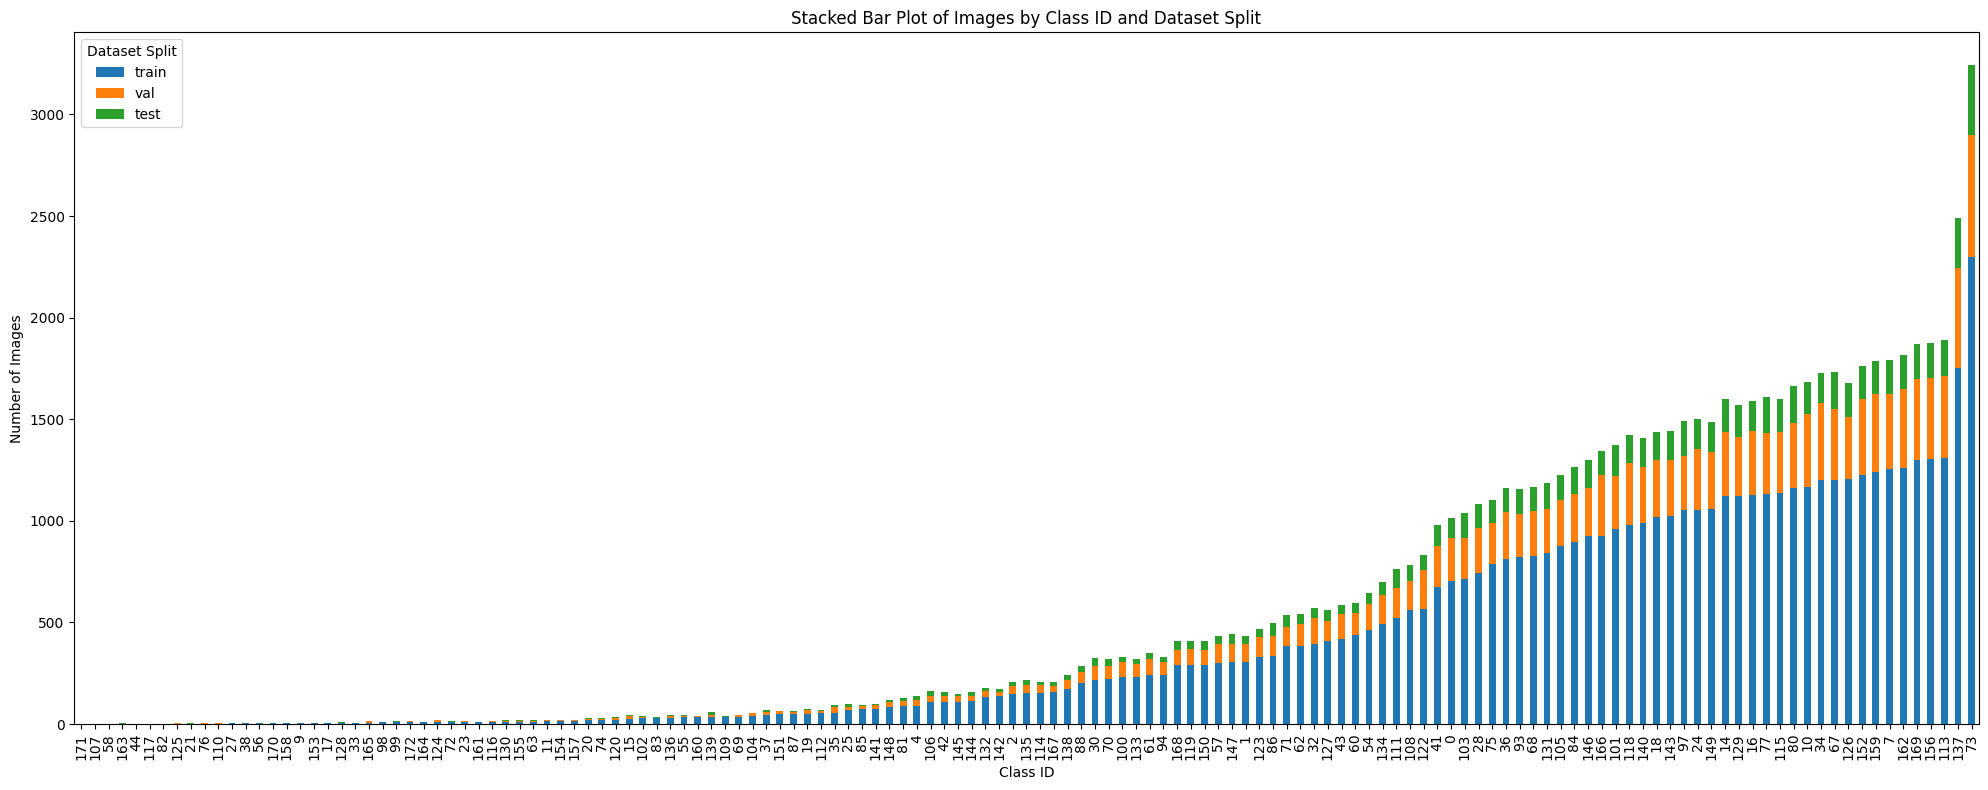

In [57]:
df_pivot_images_P00 = df_investigate_split_P00.pivot_table(index='class_id', columns='set', values='# images')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_images_P00.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Stacked Bar Plot of Images by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

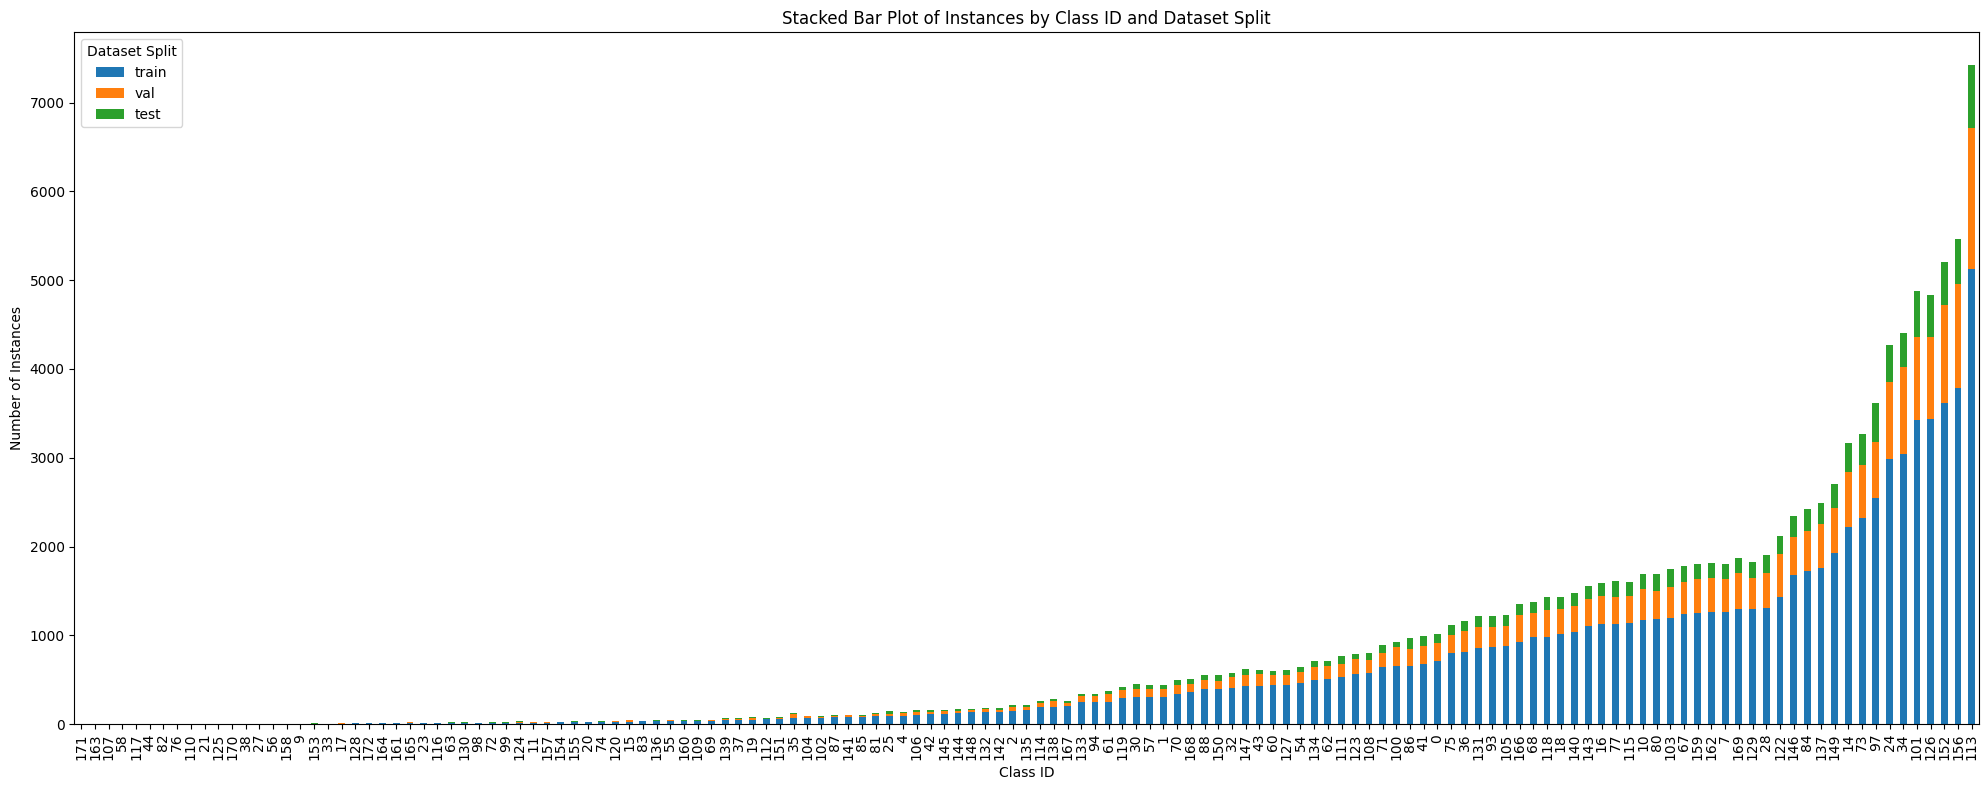

In [58]:
df_pivot_instances_P00 = df_investigate_split_P00.pivot_table(index='class_id', columns='set', values='# instances')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_instances_P00.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Stacked Bar Plot of Instances by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

# drop P25

In [59]:
shutil.copytree(local_paths['image_label_P00_dir'], local_paths['image_label_P25_dir'])

PosixPath('/content/dataset_v2_ALL/image_label_P25')

## investigate dataset

In [60]:
#before remove
all_images_P25 = sorted([Path(local_paths['image_label_P25_dir'], f) for f in Path.iterdir(local_paths['image_label_P25_dir']) if f.suffix == '.jpg'])
print(len(all_images_P25))
write_image_paths(all_images_P25, local_paths['all_paths_P25'])

10556


In [61]:
class_ids_P25 = class_ids_P00.copy()
investigate_all_P25, empty_label_list_P25 = investigate_set(local_paths['all_paths_P25'], class_ids_P25)
print(len(investigate_all_P25))
print(f'after investigation, there are {len(empty_label_list_P25)} data with no labels')

139
after investigation, there are 0 data with no labels


In [62]:
if not Path(local_paths['empty_data_P25_dir']).exists():
    Path.mkdir(local_paths['empty_data_P25_dir'])
count = 0
for image_id in empty_label_list_P25:
    shutil.move(Path(local_paths['image_label_P25_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P25_dir'])
    shutil.move(Path(local_paths['image_label_P25_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P25_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 0


In [63]:
df_investigate_all_P25 = investigation_dict2df(investigate_all_P25)

139


In [64]:
df_investigate_all_P25.to_csv('/content/dataset_v2_ALL/investigate_all_P25.csv')

/tmp/ipython-input-65-1237102296.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all_P00 \


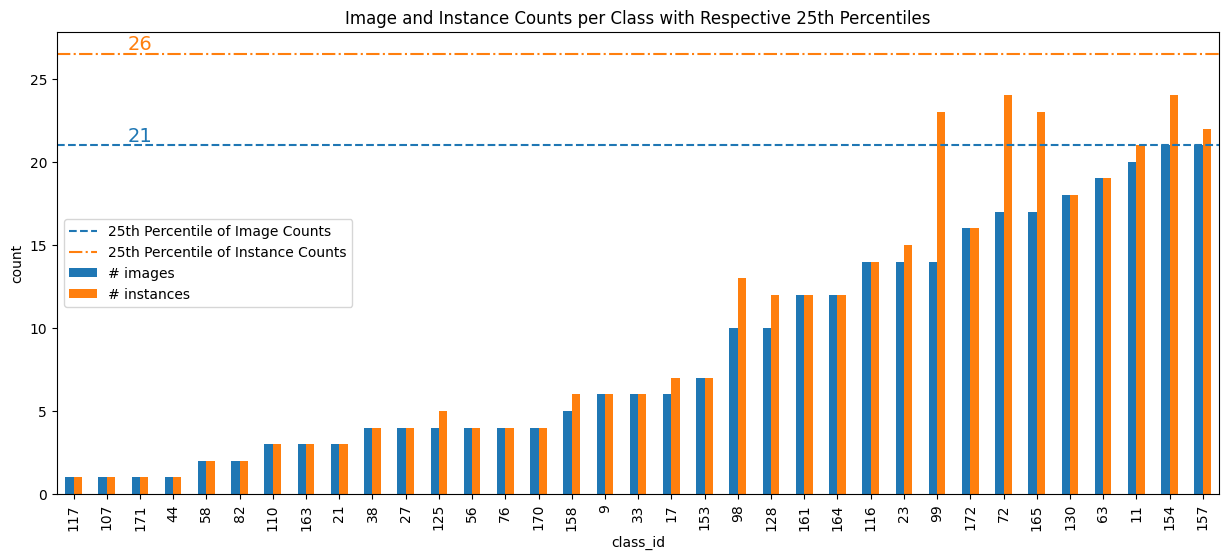

In [65]:
df_investigate_all_P00 \
    .sort_values(by='# images')[
        (df_investigate_all_P00['# images'] <= percentiles_image[0]) &
         (df_investigate_all_P00['# instances'] <= percentiles_instance[0])] \
    .plot.bar(y=['# images', '# instances'], figsize=(15,6))
plt.axhline(y=percentiles_image[0], color='#1f77b4', linestyle='--', label='25th Percentile of Image Counts')
plt.axhline(y=percentiles_instance[0], color='#ff7f0e', linestyle='dashdot', label='25th Percentile of Instance Counts')
plt.text(2, percentiles_image[0], f'{int(percentiles_image[0])}', va='bottom', ha='center', color='#1f77b4', fontsize=14)
plt.text(2, percentiles_instance[0], f'{int(percentiles_instance[0])}', va='bottom', ha='center', color='#ff7f0e', fontsize=14)
plt.title('Image and Instance Counts per Class with Respective 25th Percentiles')
plt.legend()
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

In [66]:
df_investigate_all_P25_drop = df_investigate_all_P25[
    (df_investigate_all_P25['# images'] <= percentiles_image[0]) &
    (df_investigate_all_P25['# instances'] <= percentiles_instance[0])
]
print(df_investigate_all_P25_drop.sort_values(by=['# images']).index)
print(len(df_investigate_all_P25_drop.index))

Index([107,  44, 117, 171,  58,  82, 163,  21, 110, 170,  27, 125,  38,  56,
        76, 158,   9,  17,  33, 153,  98, 128, 164, 161, 116,  99,  23, 172,
        72, 165, 130,  63,  11, 157, 154],
      dtype='int64')
35


In [67]:
df_investigate_all_P25_keep = df_investigate_all_P25[
    (df_investigate_all_P25['# images'] > percentiles_image[0]) |
    (df_investigate_all_P25['# instances'] > percentiles_instance[0])
]
print(df_investigate_all_P25_keep.index)
print(len(df_investigate_all_P25_keep.index))

Index([  0,   1,   2,   4,   7,  10,  14,  15,  16,  18,
       ...
       152, 155, 156, 159, 160, 162, 166, 167, 168, 169],
      dtype='int64', length=104)
104


In [68]:
print(len(set(df_investigate_all_P25_keep.index).union(set(df_investigate_all_P25_keep.index))))

104


In [69]:
investigate_all_P25_drop = {k: v for k, v in investigate_all_P25.items() if k not in df_investigate_all_P25_keep.index}
len(investigate_all_P25_drop)

35

In [70]:
investigate_all_P25_keep = {k: v for k, v in investigate_all_P25.items() if k in df_investigate_all_P25_keep.index}
len(investigate_all_P25_keep)

104

## get class names

In [71]:
class_ids_P25 = set(sorted(investigate_all_P25_keep.keys()))
print(len(class_ids_P25))

104


In [72]:
class_names_P25 = [new_class_dict[str(id)] if id in class_ids_P25 else '' for id in range(list(class_ids_P25)[-1] + 1)]
print('Class names in order:', class_names_P25)
print(len([name for name in class_names_P25 if name != '']))

Class names in order: ['1.0', '1.1', '1.2', '', '1.7', '', '', '2.0', '', '', '3.0', '', '', '', '5.0', '5.1', '6.0', '', '7.0', '7.1', '7.2', '', '', '', '8.0', '8.3', '', '', '9.0', '', '9.4', '', '10.0', '', '11.0', '11.1', '13.0', '13.1', '', '', '', '14.0', '14.1', '14.2', '', '', '', '', '', '', '', '', '', '', '19.0', '19.1', '', '19.3', '', '', '20.0', '20.1', '20.2', '', '', '', '', '23.0', '23.1', '23.2', '24.0', '24.1', '', '26.0', '26.1', '27.0', '', '28.0', '', '', '29.0', '29.1', '', '29.4', '30.0', '30.1', '32.0', '32.1', '32.2', '', '', '', '', '35.0', '35.1', '', '', '37.0', '', '', '37.4', '38.0', '38.1', '39.0', '39.1', '40.0', '40.1', '', '41.0', '41.1', '', '42.0', '42.1', '43.0', '43.1', '44.0', '', '', '45.0', '45.1', '45.2', '', '46.0', '46.1', '46.3', '', '47.0', '47.1', '', '48.0', '', '49.0', '49.3', '49.4', '50.0', '50.1', '50.2', '51.0', '51.2', '51.3', '52.0', '52.3', '52.5', '53.0', '53.4', '53.5', '54.0', '54.4', '54.5', '55.0', '55.4', '55.5', '56.0', '

In [73]:
with open(local_paths['class_names_P25'], 'w') as f:
    f.writelines([f'{name}\n' for name in class_names_P25])

## remove data

In [74]:
if not Path(local_paths['label_id_backup_P25_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_P25_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_P25_dir'],
    backup_dir=local_paths['label_id_backup_P25_dir'],
    class_ids_to_remove=set(df_investigate_all_P25_drop.index)
)
print(num_files_processed)

Processed 2022_11_23_10_11_08-TBHP047075HO.txt: 1 lines removed, original backed up
Processed 2022_11_17_14_51_50-TNNP063255HO.txt: 1 lines removed, original backed up
Processed 2022_11_28_11_13_02-NBHP013130HO.txt: 2 lines removed, original backed up
Processed 2022_11_18_14_27_15-HDGP004037HO.txt: 1 lines removed, original backed up
Processed 2022_11_11_09_24_07-CBGP002144HO.txt: 2 lines removed, original backed up
Processed 2022_11_16_10_52_25-TVHP004310HO.txt: 1 lines removed, original backed up
Processed 2022_11_09_14_47_29-HNIP121047HO.txt: 1 lines removed, original backed up
Processed 2022_11_17_15_38_41-HPGP098451HO.txt: 1 lines removed, original backed up
Processed 2022_11_17_16_25_39-HGGP017470HO.txt: 1 lines removed, original backed up
Processed 2022_11_14_11_19_03-KTMP021127HO.txt: 1 lines removed, original backed up
Processed 2022_11_14_13_27_25-HDGP008124HO.txt: 1 lines removed, original backed up
Processed 2022_11_19_10_14_32-DTPP001056HO.txt: 1 lines removed, original ba

In [75]:
all_images_P25 = sorted([Path(local_paths['image_label_P25_dir'], f) for f in Path.iterdir(local_paths['image_label_P25_dir']) if f.suffix == '.jpg'])
print(len(all_images_P25))
write_image_paths(all_images_P25, local_paths['all_paths_P25'])

10556


In [76]:
_, empty_label_list_P25 = investigate_set(local_paths['all_paths_P25'], class_ids_P25)

In [77]:
print(f'after investigation, there are {len(empty_label_list_P25)} data with no labels')

after investigation, there are 1 data with no labels


In [78]:
if not Path(local_paths['empty_data_P00_dir']).exists():
    Path.mkdir(local_paths['empty_data_P25_dir'])
count = 0
for image_id in empty_label_list_P25:
    shutil.move(Path(local_paths['image_label_P25_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P25_dir'])
    shutil.move(Path(local_paths['image_label_P25_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P25_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 2


In [79]:
all_images_P25 = sorted([Path(local_paths['image_label_P25_dir'], f) for f in Path.iterdir(local_paths['image_label_P25_dir']) if f.suffix == '.jpg'])
print(len(all_images_P25))
write_image_paths(all_images_P25, local_paths['all_paths_P25'])

10555


## Split dataset & save dataset division

In [80]:
new_all_images_P25 = all_images_P25.copy()
train_images = []
val_images = []
test_images = []
for i in range(1000):
    for itrain in range(70):
        if len(new_all_images_P25) == 0:
            continue
        train_images.append(new_all_images_P25.pop(0))
    for ival in range(20):
        if len(new_all_images_P25) == 0:
            continue
        val_images.append(new_all_images_P25.pop(0))
    for itest in range(10):
        if len(new_all_images_P25) == 0:
            continue
        test_images.append(new_all_images_P25.pop(0))

In [81]:
print(len(train_images))

7405


In [82]:
write_image_paths(train_images, local_paths['train_paths_P25'])
write_image_paths(val_images, local_paths['val_paths_P25'])
write_image_paths(test_images, local_paths['test_paths_P25'])

In [83]:
investigate_train_P25, _ = investigate_set(local_paths['train_paths_P25'], class_ids_P25)
investigate_val_P25, _ = investigate_set(local_paths['val_paths_P25'], class_ids_P25)
investigate_test_P25, _ = investigate_set(local_paths['test_paths_P25'], class_ids_P25)

In [84]:
df_investigate_train_P25 = investigation_dict2df(investigate_train_P25)
df_investigate_val_P25 = investigation_dict2df(investigate_val_P25)
df_investigate_test_P25 = investigation_dict2df(investigate_test_P25)

104
104
104


In [85]:
df_investigate_train_P25['set'] = 'train'
df_investigate_val_P25['set'] = 'val'
df_investigate_test_P25['set'] = 'test'

In [86]:
df_investigate_split_P25 = pd.concat([df_investigate_train_P25, df_investigate_val_P25, df_investigate_test_P25], axis=0, ignore_index=True)
df_investigate_split_P25

class_id class_name # images # instances    set
0          0        1.0      706         707  train
1          1        1.1      303         304  train
2          2        1.2      146         146  train
3          4        1.7       90          94  train
4          7        2.0     1252        1264  train
..       ...        ...      ...         ...    ...
307      162       59.0      170         170   test
308      166       60.0      121         121   test
309      167       60.1       18          22   test
310      168       60.3       45          53   test
311      169       61.0      177         177   test

[312 rows x 5 columns]

In [87]:
df_investigate_split_P25.to_csv('/content/dataset_v2_ALL/split_P25.csv')

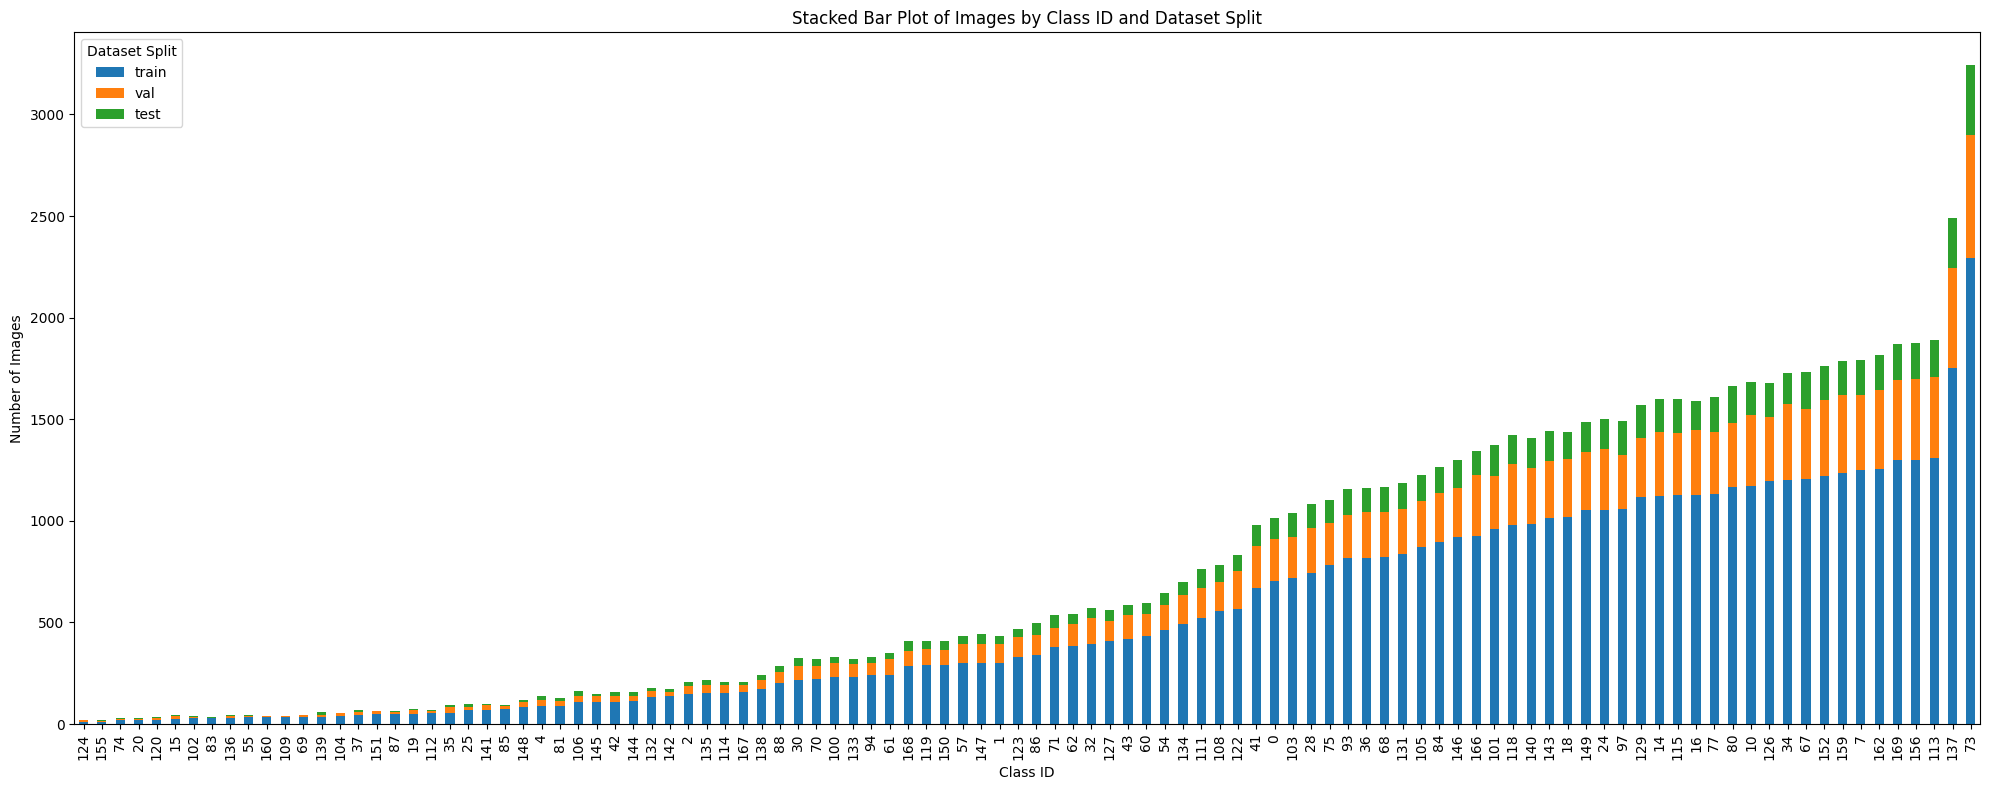

In [88]:
df_pivot_images_P25 = df_investigate_split_P25.pivot_table(index='class_id', columns='set', values='# images')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_images_P25.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Stacked Bar Plot of Images by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

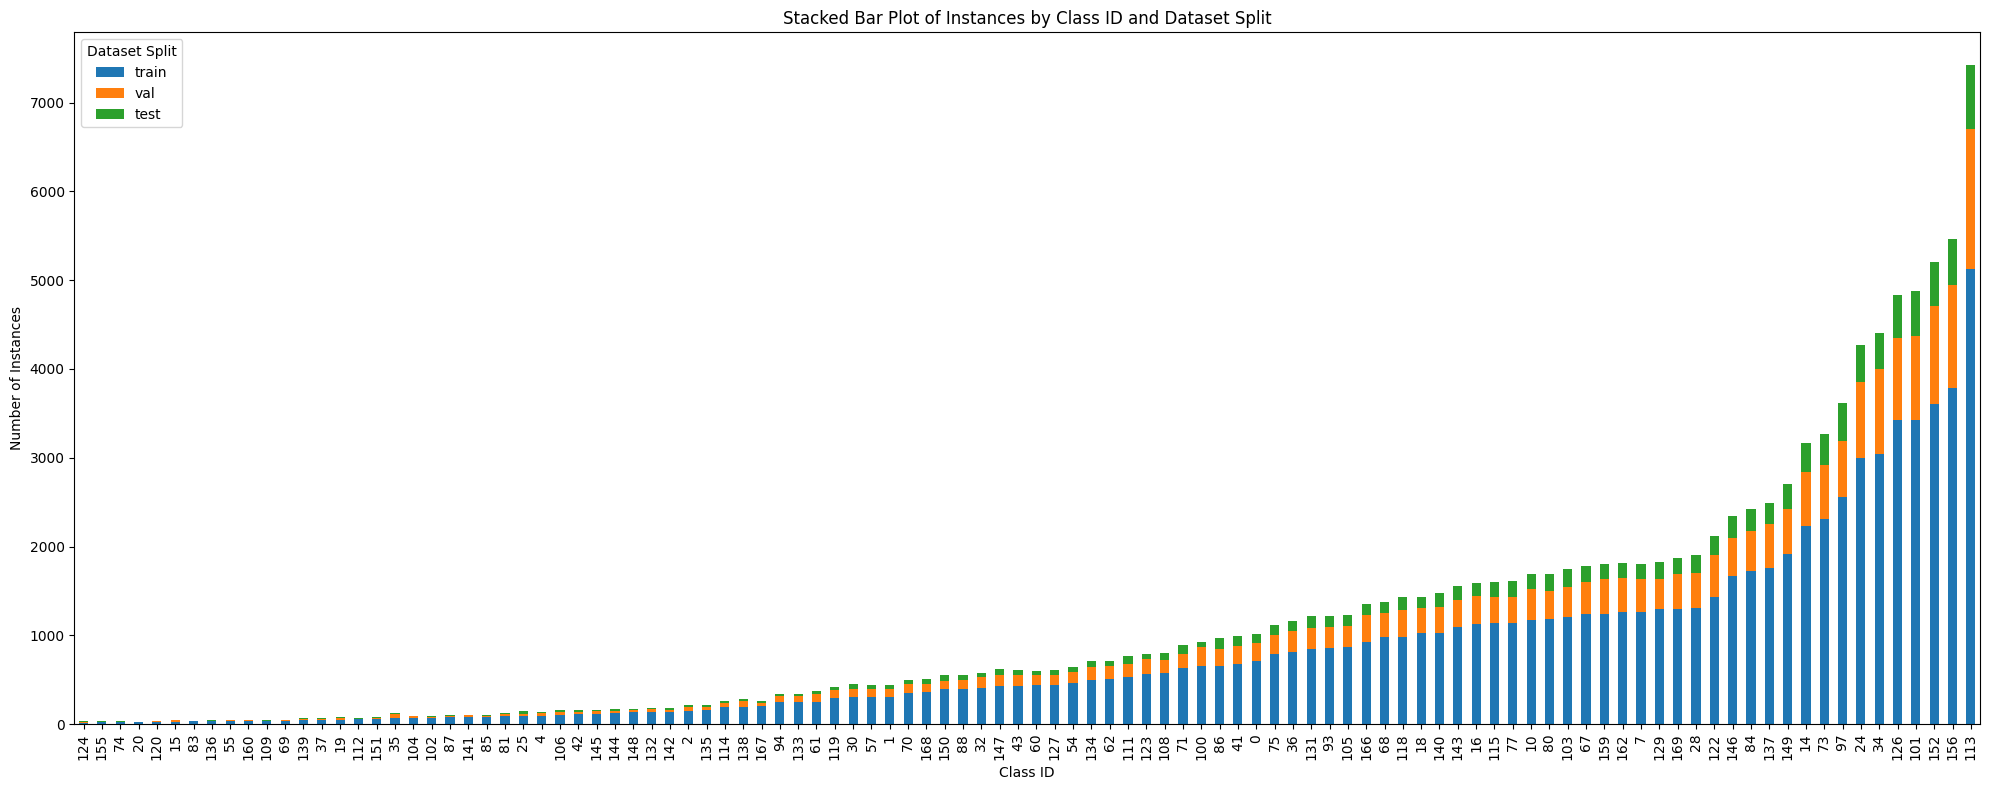

In [89]:
df_pivot_instances_P25 = df_investigate_split_P25.pivot_table(index='class_id', columns='set', values='# instances')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_instances_P25.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Stacked Bar Plot of Instances by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

# drop P30

In [90]:
shutil.copytree(local_paths['image_label_P25_dir'], local_paths['image_label_P30_dir'])

PosixPath('/content/dataset_v2_ALL/image_label_P30')

## investigate dataset

In [91]:
#before remove
all_images_P30 = sorted([Path(local_paths['image_label_P30_dir'], f) for f in Path.iterdir(local_paths['image_label_P30_dir']) if f.suffix == '.jpg'])
print(len(all_images_P30))
write_image_paths(all_images_P30, local_paths['all_paths_P30'])

10555


In [92]:
class_ids_P30 = class_ids_P25.copy()
investigate_all_P30, empty_label_list_P30 = investigate_set(local_paths['all_paths_P30'], class_ids_P30)
print(len(investigate_all_P30))
print(f'after investigation, there are {len(empty_label_list_P30)} data with no labels')

104
after investigation, there are 0 data with no labels


In [93]:
if not Path(local_paths['empty_data_P30_dir']).exists():
    Path.mkdir(local_paths['empty_data_P30_dir'])
count = 0
for image_id in empty_label_list_P30:
    shutil.move(Path(local_paths['image_label_P30_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P30_dir'])
    shutil.move(Path(local_paths['image_label_P30_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P30_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 0


In [94]:
df_investigate_all_P30 = investigation_dict2df(investigate_all_P30)

104


In [95]:
df_investigate_all_P30.to_csv('/content/dataset_v2_ALL/investigate_all_P30.csv')

/tmp/ipython-input-96-2106501771.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all_P00 \


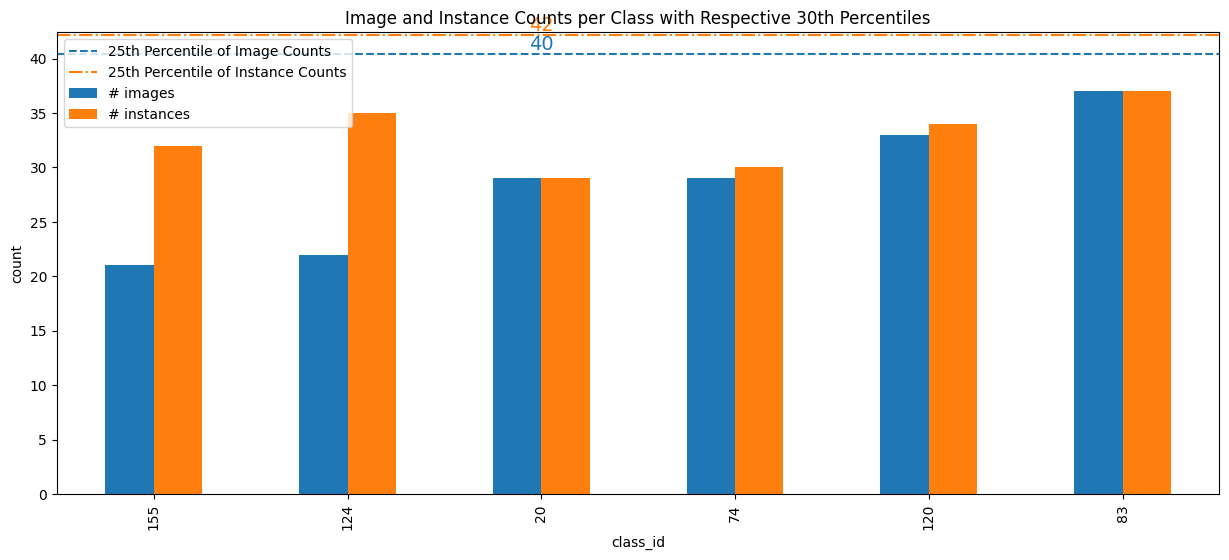

In [96]:
df_investigate_all_P00 \
    .sort_values(by='# images')[
        ((df_investigate_all_P00['# images'] <= percentiles_image[1]) &
         (df_investigate_all_P00['# instances'] <= percentiles_instance[1])) &
        ((df_investigate_all_P00['# images'] > percentiles_image[0]) |
         (df_investigate_all_P00['# instances'] > percentiles_instance[0]))] \
    .plot.bar(y=['# images', '# instances'], figsize=(15,6))
plt.axhline(y=percentiles_image[1], color='#1f77b4', linestyle='--', label='25th Percentile of Image Counts')
plt.axhline(y=percentiles_instance[1], color='#ff7f0e', linestyle='dashdot', label='25th Percentile of Instance Counts')
plt.text(2, percentiles_image[1], f'{int(percentiles_image[1])}', va='bottom', ha='center', color='#1f77b4', fontsize=14)
plt.text(2, percentiles_instance[1], f'{int(percentiles_instance[1])}', va='bottom', ha='center', color='#ff7f0e', fontsize=14)
plt.title('Image and Instance Counts per Class with Respective 30th Percentiles')
plt.legend()
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

In [97]:
df_investigate_all_P30_drop = df_investigate_all_P30[
    ((df_investigate_all_P30['# images'] <= percentiles_image[1]) &
    (df_investigate_all_P30['# instances'] <= percentiles_instance[1])) &
    ((df_investigate_all_P30['# images'] > percentiles_image[0]) |
    (df_investigate_all_P30['# instances'] > percentiles_instance[0]))
]
print(df_investigate_all_P30_drop.sort_values(by=['# images']).index)
print(len(df_investigate_all_P30_drop.index))

Index([155, 124, 20, 74, 120, 83], dtype='int64')
6


In [98]:
df_investigate_all_P30_keep = df_investigate_all_P30[
    (df_investigate_all_P30['# images'] > percentiles_image[1]) |
    (df_investigate_all_P30['# instances'] > percentiles_instance[1])
]
print(df_investigate_all_P30_keep.index)
print(len(df_investigate_all_P30_keep.index))

Index([  0,   1,   2,   4,   7,  10,  14,  15,  16,  18,  19,  24,  25,  28,
        30,  32,  34,  35,  36,  37,  41,  42,  43,  54,  55,  57,  60,  61,
        62,  67,  68,  69,  70,  71,  73,  75,  77,  80,  81,  84,  85,  86,
        87,  88,  93,  94,  97, 100, 101, 102, 103, 104, 105, 106, 108, 109,
       111, 112, 113, 114, 115, 118, 119, 122, 123, 126, 127, 129, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 156, 159, 160, 162, 166, 167, 168, 169],
      dtype='int64')
98


In [99]:
print(len(set(df_investigate_all_P30_keep.index).union(set(df_investigate_all_P30_keep.index))))

98


In [100]:
investigate_all_P30_drop = {k: v for k, v in investigate_all_P30.items() if k not in df_investigate_all_P30_keep.index}
len(investigate_all_P30_drop)

6

In [101]:
investigate_all_P30_keep = {k: v for k, v in investigate_all_P30.items() if k in df_investigate_all_P30_keep.index}
len(investigate_all_P30_keep)

98

## get class names

In [102]:
class_ids_P30 = set(sorted(investigate_all_P30_keep.keys()))
print(len(class_ids_P30))

98


In [103]:
class_names_P30 = [new_class_dict[str(id)] if id in class_ids_P30 else '' for id in range(list(class_ids_P30)[-1] + 1)]
print('Class names in order:', class_names_P30)
print(len([name for name in class_names_P30 if name != '']))

Class names in order: ['1.0', '1.1', '1.2', '', '1.7', '', '', '2.0', '', '', '3.0', '', '', '', '5.0', '5.1', '6.0', '', '7.0', '7.1', '', '', '', '', '8.0', '8.3', '', '', '9.0', '', '9.4', '', '10.0', '', '11.0', '11.1', '13.0', '13.1', '', '', '', '14.0', '14.1', '14.2', '', '', '', '', '', '', '', '', '', '', '19.0', '19.1', '', '19.3', '', '', '20.0', '20.1', '20.2', '', '', '', '', '23.0', '23.1', '23.2', '24.0', '24.1', '', '26.0', '', '27.0', '', '28.0', '', '', '29.0', '29.1', '', '', '30.0', '30.1', '32.0', '32.1', '32.2', '', '', '', '', '35.0', '35.1', '', '', '37.0', '', '', '37.4', '38.0', '38.1', '39.0', '39.1', '40.0', '40.1', '', '41.0', '41.1', '', '42.0', '42.1', '43.0', '43.1', '44.0', '', '', '45.0', '45.1', '', '', '46.0', '46.1', '', '', '47.0', '47.1', '', '48.0', '', '49.0', '49.3', '49.4', '50.0', '50.1', '50.2', '51.0', '51.2', '51.3', '52.0', '52.3', '52.5', '53.0', '53.4', '53.5', '54.0', '54.4', '54.5', '55.0', '55.4', '55.5', '56.0', '', '', '', '57.0', 

In [104]:
with open(local_paths['class_names_P30'], 'w') as f:
    f.writelines([f'{name}\n' for name in class_names_P30])

## remove data

In [105]:
if not Path(local_paths['label_id_backup_P30_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_P30_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_P30_dir'],
    backup_dir=local_paths['label_id_backup_P30_dir'],
    class_ids_to_remove=set(df_investigate_all_P30_drop.index)
)
print(num_files_processed)

Processed 2022_11_09_17_15_46-TGGP030172HO.txt: 1 lines removed, original backed up
Processed 2022_11_05_15_20_02-DNIP104210HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_11_48_04-QNHP110046HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_12_45_50-HNIP386041HO.txt: 1 lines removed, original backed up
Processed 2022_11_09_08_46_51-BRUP063186HO.txt: 1 lines removed, original backed up
Processed 2022_11_07_10_22_28-TNHP036122HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_15_43_33-TNNP033195HO.txt: 1 lines removed, original backed up
Processed 2022_11_17_09_18_21-QNHP050122HO.txt: 1 lines removed, original backed up
Processed 2022_11_14_12_09_37-HDGP103090HO.txt: 1 lines removed, original backed up
Processed 2022_10_28_10_03_45-AGGP023339HO.txt: 1 lines removed, original backed up
Processed 2022_11_09_09_36_49-TNHP007293HO.txt: 1 lines removed, original backed up
Processed 2022_11_04_10_23_45-GLIP041213HO.txt: 1 lines removed, original ba

In [106]:
all_images_P30 = sorted([Path(local_paths['image_label_P30_dir'], f) for f in Path.iterdir(local_paths['image_label_P30_dir']) if f.suffix == '.jpg'])
print(len(all_images_P30))
write_image_paths(all_images_P30, local_paths['all_paths_P30'])

10555


In [107]:
_, empty_label_list_P30 = investigate_set(local_paths['all_paths_P30'], class_ids_P30)

In [108]:
print(f'after investigation, there are {len(empty_label_list_P30)} data with no labels')

after investigation, there are 1 data with no labels


In [109]:
if not Path(local_paths['empty_data_P00_dir']).exists():
    Path.mkdir(local_paths['empty_data_P30_dir'])
count = 0
for image_id in empty_label_list_P30:
    shutil.move(Path(local_paths['image_label_P30_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P30_dir'])
    shutil.move(Path(local_paths['image_label_P30_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P30_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 2


In [110]:
all_images_P30 = sorted([Path(local_paths['image_label_P30_dir'], f) for f in Path.iterdir(local_paths['image_label_P30_dir']) if f.suffix == '.jpg'])
print(len(all_images_P30))
write_image_paths(all_images_P30, local_paths['all_paths_P30'])

10554


## Split dataset & save dataset division

In [111]:
new_all_images_P30 = all_images_P30.copy()
train_images = []
val_images = []
test_images = []
for i in range(1000):
    for itrain in range(70):
        if len(new_all_images_P30) == 0:
            continue
        train_images.append(new_all_images_P30.pop(0))
    for ival in range(20):
        if len(new_all_images_P30) == 0:
            continue
        val_images.append(new_all_images_P30.pop(0))
    for itest in range(10):
        if len(new_all_images_P30) == 0:
            continue
        test_images.append(new_all_images_P30.pop(0))

In [112]:
print(len(train_images))

7404


In [113]:
write_image_paths(train_images, local_paths['train_paths_P30'])
write_image_paths(val_images, local_paths['val_paths_P30'])
write_image_paths(test_images, local_paths['test_paths_P30'])

In [114]:
investigate_train_P30, _ = investigate_set(local_paths['train_paths_P30'], class_ids_P30)
investigate_val_P30, _ = investigate_set(local_paths['val_paths_P30'], class_ids_P30)
investigate_test_P30, _ = investigate_set(local_paths['test_paths_P30'], class_ids_P30)

In [115]:
df_investigate_train_P30 = investigation_dict2df(investigate_train_P30)
df_investigate_val_P30 = investigation_dict2df(investigate_val_P30)
df_investigate_test_P30 = investigation_dict2df(investigate_test_P30)

98
98
98


In [116]:
df_investigate_train_P30['set'] = 'train'
df_investigate_val_P30['set'] = 'val'
df_investigate_test_P30['set'] = 'test'

In [117]:
df_investigate_split_P30 = pd.concat([df_investigate_train_P30, df_investigate_val_P30, df_investigate_test_P30], axis=0, ignore_index=True)
df_investigate_split_P30

class_id class_name # images # instances    set
0          0        1.0      713         714  train
1          1        1.1      302         303  train
2          2        1.2      146         146  train
3          4        1.7       88          92  train
4          7        2.0     1256        1268  train
..       ...        ...      ...         ...    ...
289      162       59.0      175         175   test
290      166       60.0      123         124   test
291      167       60.1       21          25   test
292      168       60.3       46          52   test
293      169       61.0      181         181   test

[294 rows x 5 columns]

In [118]:
df_investigate_split_P30.to_csv('/content/dataset_v2_ALL/split_P30.csv')

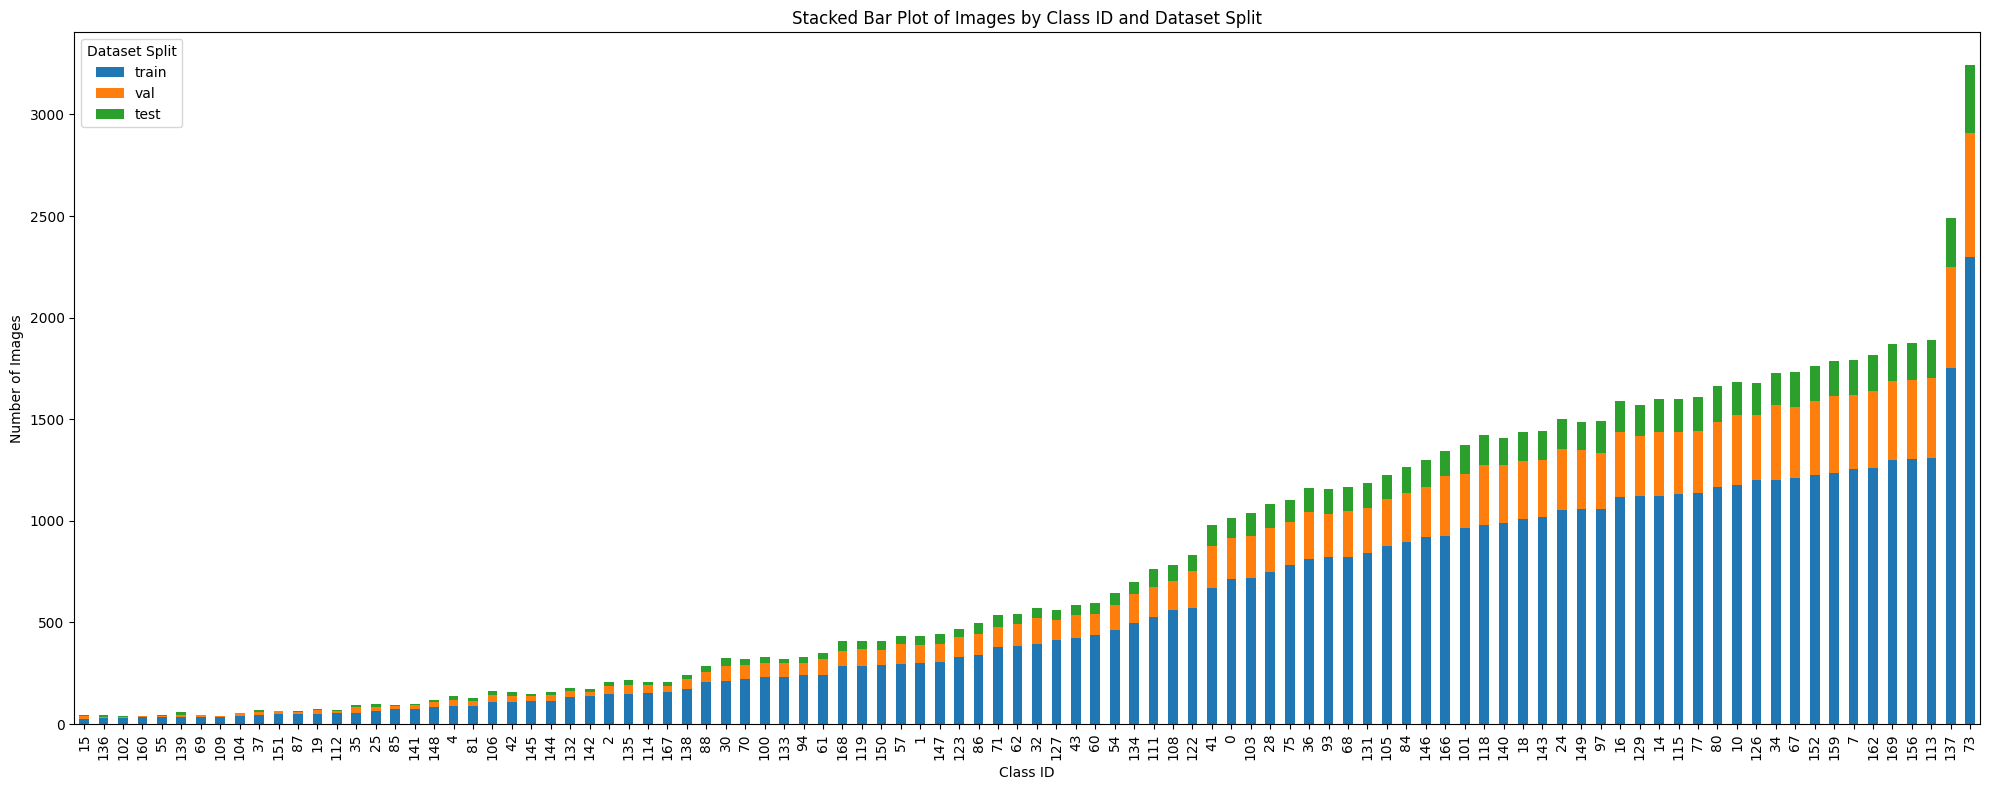

In [119]:
df_pivot_images_P30 = df_investigate_split_P30.pivot_table(index='class_id', columns='set', values='# images')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_images_P30.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Stacked Bar Plot of Images by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

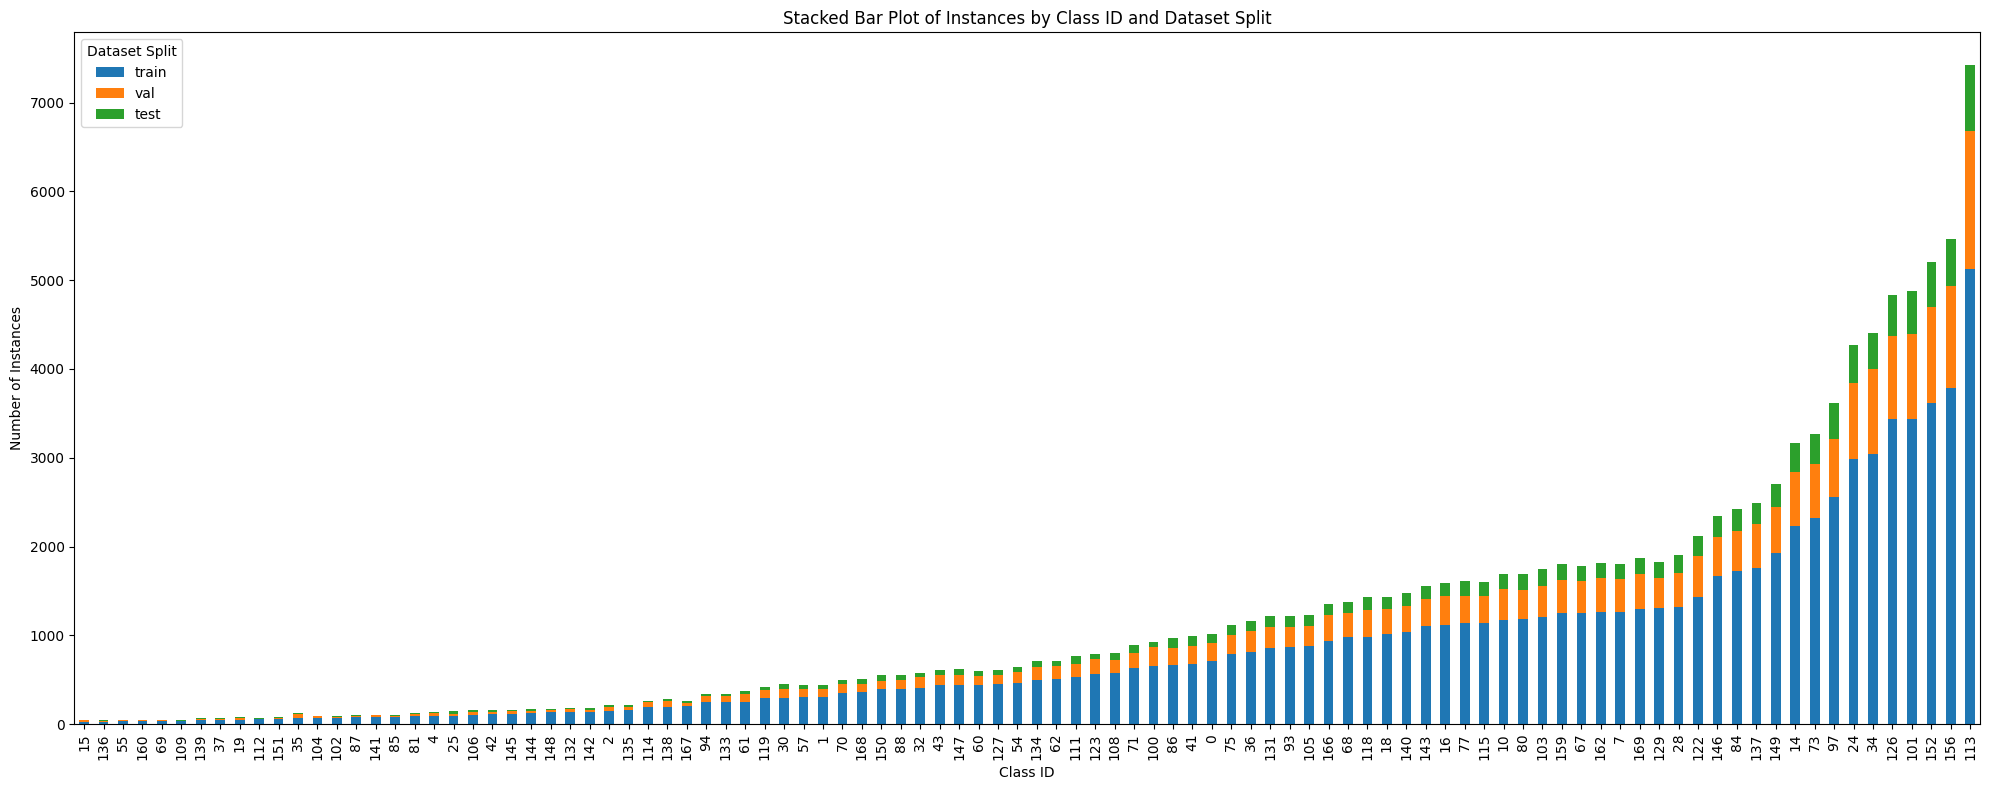

In [120]:
df_pivot_instances_P30 = df_investigate_split_P30.pivot_table(index='class_id', columns='set', values='# instances')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_instances_P30.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Stacked Bar Plot of Instances by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

# P30

## investigate dataset

In [ ]:
len(investigate_all_P25_keep)

104

In [ ]:
df_investigate_all_P25_keep.sample(5)

class_id  # images  # instances
138       138       240          287
77         77      1609         1610
133       133       322          344
94         94       331          343
145       145       148          156

/tmp/ipython-input-45-1939621825.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all \


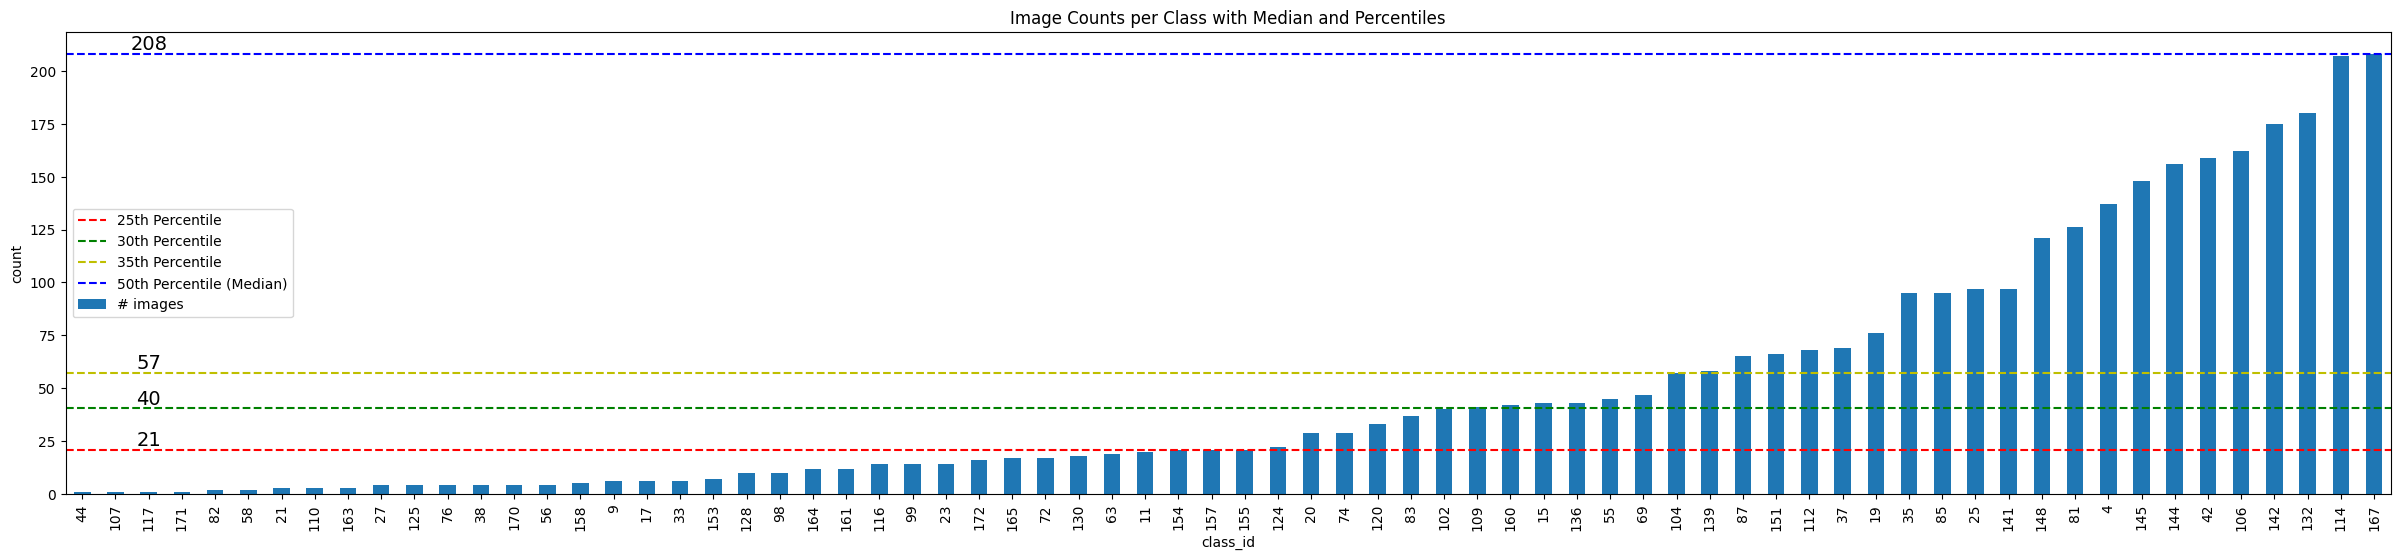

In [ ]:
df_investigate_all \
    .sort_values(by='# images')[df_investigate_all['# images'] <= percentiles_image[3]] \
    .plot.bar(y=['# images'], figsize=(30,6))
plt.axhline(y=percentiles_image[0], color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=percentiles_image[1], color='g', linestyle='--', label='30th Percentile')
plt.axhline(y=percentiles_image[2], color='y', linestyle='--', label='35th Percentile')
plt.axhline(y=percentiles_image[3], color='b', linestyle='--', label='50th Percentile (Median)')
plt.title('Image Counts per Class with Median and Percentiles')
plt.legend()
for p in percentiles_image:
    plt.text(2, p, f'{int(p)}', va='bottom', ha='center', color='black', fontsize=14)
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

/tmp/ipython-input-65-1182977439.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all_P25_keep \


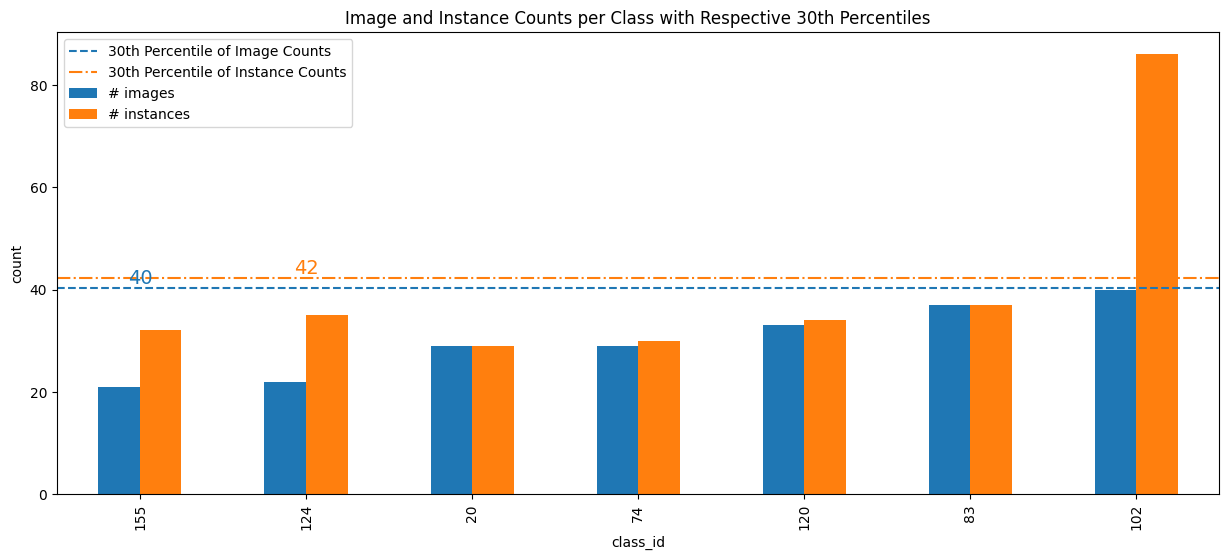

In [ ]:
df_investigate_all_P25_keep \
    .sort_values(by='# images')[
        df_investigate_all_P25_keep['# images'] <= percentiles_image[1]
    ].plot.bar(y=['# images', '# instances'], figsize=(15,6))
plt.axhline(y=percentiles_image[1], color='#1f77b4', linestyle='--', label='30th Percentile of Image Counts')
plt.axhline(y=percentiles_instance[1], color='#ff7f0e', linestyle='dashdot', label='30th Percentile of Instance Counts')
plt.text(0, percentiles_image[1], f'{int(percentiles_image[1])}', va='bottom', ha='center', color='#1f77b4', fontsize=14)
plt.text(1, percentiles_instance[1], f'{int(percentiles_instance[1])}', va='bottom', ha='center', color='#ff7f0e', fontsize=14)
plt.title('Image and Instance Counts per Class with Respective 30th Percentiles')
plt.legend()
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

drop those below P30

In [ ]:
df_investigate_all_P30_drop = df_investigate_all_P25_keep[
    (df_investigate_all_P25_keep['# images'] <= percentiles_image[1]) &
    (df_investigate_all_P25_keep['# instances'] <= percentiles_instance[1])
]
print(df_investigate_all_P30_drop.index)
print(len(df_investigate_all_P30_drop.index))

Index([20, 74, 83, 120, 124, 155], dtype='int64')
6


In [ ]:
df_investigate_all_P30_keep = df_investigate_all_P25_keep[
    (df_investigate_all_P25_keep['# images'] > percentiles_image[1]) |
    (df_investigate_all_P25_keep['# instances'] > percentiles_instance[1])
]
print(df_investigate_all_P30_keep.index)
print(len(df_investigate_all_P30_keep.index))

Index([  0,   1,   2,   4,   7,  10,  14,  15,  16,  18,  19,  24,  25,  28,
        30,  32,  34,  35,  36,  37,  41,  42,  43,  54,  55,  57,  60,  61,
        62,  67,  68,  69,  70,  71,  73,  75,  77,  80,  81,  84,  85,  86,
        87,  88,  93,  94,  97, 100, 101, 102, 103, 104, 105, 106, 108, 109,
       111, 112, 113, 114, 115, 118, 119, 122, 123, 126, 127, 129, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 156, 159, 160, 162, 166, 167, 168, 169],
      dtype='int64')
98


In [ ]:
investigate_all_P30_drop = {k: v for k, v in investigate_all_P25_keep.items() if k not in df_investigate_all_P30_keep.index}
len(investigate_all_P30_drop)

6

In [ ]:
investigate_all_P30_keep = {k: v for k, v in investigate_all_P25_keep.items() if k in df_investigate_all_P30_keep.index}
len(investigate_all_P30_keep)

98

## get class names

In [ ]:
class_ids_P30 = set(sorted(investigate_all_P30_keep.keys()))
print(len(class_ids_P30))

98


In [ ]:
class_names_P30 = [new_class_dict[str(id)] if id in class_ids_P30 else '' for id in range(list(class_ids_P30)[-1] + 1)]
print('Class names in order:', class_names_P30)
print(len([name for name in class_names_P30 if name != '']))

Class names in order: ['1.0', '1.1', '1.2', '', '1.7', '', '', '2.0', '', '', '3.0', '', '', '', '5.0', '5.1', '6.0', '', '7.0', '7.1', '', '', '', '', '8.0', '8.3', '', '', '9.0', '', '9.4', '', '10.0', '', '11.0', '11.1', '13.0', '13.1', '', '', '', '14.0', '14.1', '14.2', '', '', '', '', '', '', '', '', '', '', '19.0', '19.1', '', '19.3', '', '', '20.0', '20.1', '20.2', '', '', '', '', '23.0', '23.1', '23.2', '24.0', '24.1', '', '26.0', '', '27.0', '', '28.0', '', '', '29.0', '29.1', '', '', '30.0', '30.1', '32.0', '32.1', '32.2', '', '', '', '', '35.0', '35.1', '', '', '37.0', '', '', '37.4', '38.0', '38.1', '39.0', '39.1', '40.0', '40.1', '', '41.0', '41.1', '', '42.0', '42.1', '43.0', '43.1', '44.0', '', '', '45.0', '45.1', '', '', '46.0', '46.1', '', '', '47.0', '47.1', '', '48.0', '', '49.0', '49.3', '49.4', '50.0', '50.1', '50.2', '51.0', '51.2', '51.3', '52.0', '52.3', '52.5', '53.0', '53.4', '53.5', '54.0', '54.4', '54.5', '55.0', '55.4', '55.5', '56.0', '', '', '', '57.0', 

In [ ]:
with open(local_paths['class_names_P30'], 'w') as f:
    f.writelines([f'{name}\n' for name in class_names_P30])

## remove data

In [ ]:
if not Path(local_paths['label_id_backup_P30_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_P30_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_dir'],
    backup_dir=local_paths['label_id_backup_P30_dir'],
    class_ids_to_remove=set(df_investigate_all_P30_drop.index)
)
print(num_files_processed)

Processed 2022_10_31_08_44_00-QNMP001112HO.txt: 2 lines removed, original backed up
Processed 2022_11_04_10_23_45-GLIP041213HO.txt: 2 lines removed, original backed up
Processed 2022_11_08_15_12_34-HNIP466081HO.txt: 1 lines removed, original backed up
Processed 2022_11_23_08_18_35-QNHP052293HO.txt: 2 lines removed, original backed up
Processed 2022_11_14_08_50_46-BTEP004053HO.txt: 1 lines removed, original backed up
Processed 2022_11_11_14_20_49-BTEP015192HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_15_43_33-TNNP033195HO.txt: 1 lines removed, original backed up
Processed 2022_11_16_15_40_43-GLIP038158HO.txt: 1 lines removed, original backed up
Processed 2023_01_05_14_32_48-HNIP429999HO.txt: 1 lines removed, original backed up
Processed 2022_11_14_09_16_18-HNIP695071HO.txt: 1 lines removed, original backed up
Processed 2022_10_28_09_00_02-QNIP022002HO.txt: 1 lines removed, original backed up
Processed 2022_10_25_15_31_00-DNIP010566HO.txt: 2 lines removed, original ba

In [ ]:
all_images_P30 = sorted([Path(local_paths['image_label_dir'], f) for f in Path.iterdir(local_paths['image_label_dir']) if f.suffix == '.jpg'])
print(len(all_images_P30))
write_image_paths(all_images_P30, local_paths['all_paths_P30'])

10555


In [ ]:
_, empty_label_list_P30 = investigate_set(local_paths['all_paths_P30'], class_ids_P30)

In [ ]:
print(f'after removing labels, there are {len(empty_label_list_P30)} data with no labels')

after removing labels, there are 1 data with no labels


In [ ]:
if not Path(local_paths['empty_data_P30_dir']).exists():
    Path.mkdir(local_paths['empty_data_P30_dir'])
count = 0
for image_id in empty_label_list_P30:
    shutil.move(Path(local_paths['image_label_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P30_dir'])
    shutil.move(Path(local_paths['image_label_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P30_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 2


In [ ]:
all_images_P30 = sorted([Path(local_paths['image_label_dir'], f) for f in Path.iterdir(local_paths['image_label_dir']) if f.suffix == '.jpg'])
print(len(all_images_P30))
write_image_paths(all_images_P30, local_paths['all_paths_P30'])

10554


## Split dataset & save dataset division

In [ ]:
new_all_images_P30 = all_images_P30.copy()
train_images = []
val_images = []
test_images = []
for i in range(1000):
    for itrain in range(70):
        if len(new_all_images_P30) == 0:
            continue
        train_images.append(new_all_images_P30.pop(0))
    for ival in range(20):
        if len(new_all_images_P30) == 0:
            continue
        val_images.append(new_all_images_P30.pop(0))
    for itest in range(10):
        if len(new_all_images_P30) == 0:
            continue
        test_images.append(new_all_images_P30.pop(0))

In [ ]:
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # no shuffle!
# train_images, temp_images = train_test_split(all_images_P30, train_size=train_ratio, shuffle=False)
# val_images, test_images = train_test_split(temp_images, train_size=(val_ratio / (val_ratio + test_ratio)), shuffle=False)

In [ ]:
print(len(train_images))

7404


In [ ]:
write_image_paths(train_images, local_paths['train_paths_P30'])
write_image_paths(val_images, local_paths['val_paths_P30'])
write_image_paths(test_images, local_paths['test_paths_P30'])

In [ ]:
investigate_train_P30, _ = investigate_set(local_paths['train_paths_P30'], class_ids_P30)
investigate_val_P30, _ = investigate_set(local_paths['val_paths_P30'], class_ids_P30)
investigate_test_P30, _ = investigate_set(local_paths['test_paths_P30'], class_ids_P30)

In [ ]:
df_investigate_train_P30 = investigation_dict2df(investigate_train_P30)
df_investigate_val_P30 = investigation_dict2df(investigate_val_P30)
df_investigate_test_P30 = investigation_dict2df(investigate_test_P30)

97
97
97


In [ ]:
df_investigate_train_P30['set'] = 'train'
df_investigate_val_P30['set'] = 'val'
df_investigate_test_P30['set'] = 'test'

In [ ]:
df_investigate_split_P30 = pd.concat([df_investigate_train_P30, df_investigate_val_P30, df_investigate_test_P30], axis=0, ignore_index=True)
df_investigate_split_P30

class_id  # images  # instances    set
0           0       713          714  train
1           1       302          303  train
2           2       146          146  train
3           4        88           92  train
4           7      1256         1268  train
..        ...       ...          ...    ...
286       162       175          175   test
287       166       123          124   test
288       167        21           25   test
289       168        46           52   test
290       169       181          181   test

[291 rows x 4 columns]

In [ ]:
df_investigate_split_P30.to_csv('/content/split_P30.csv')

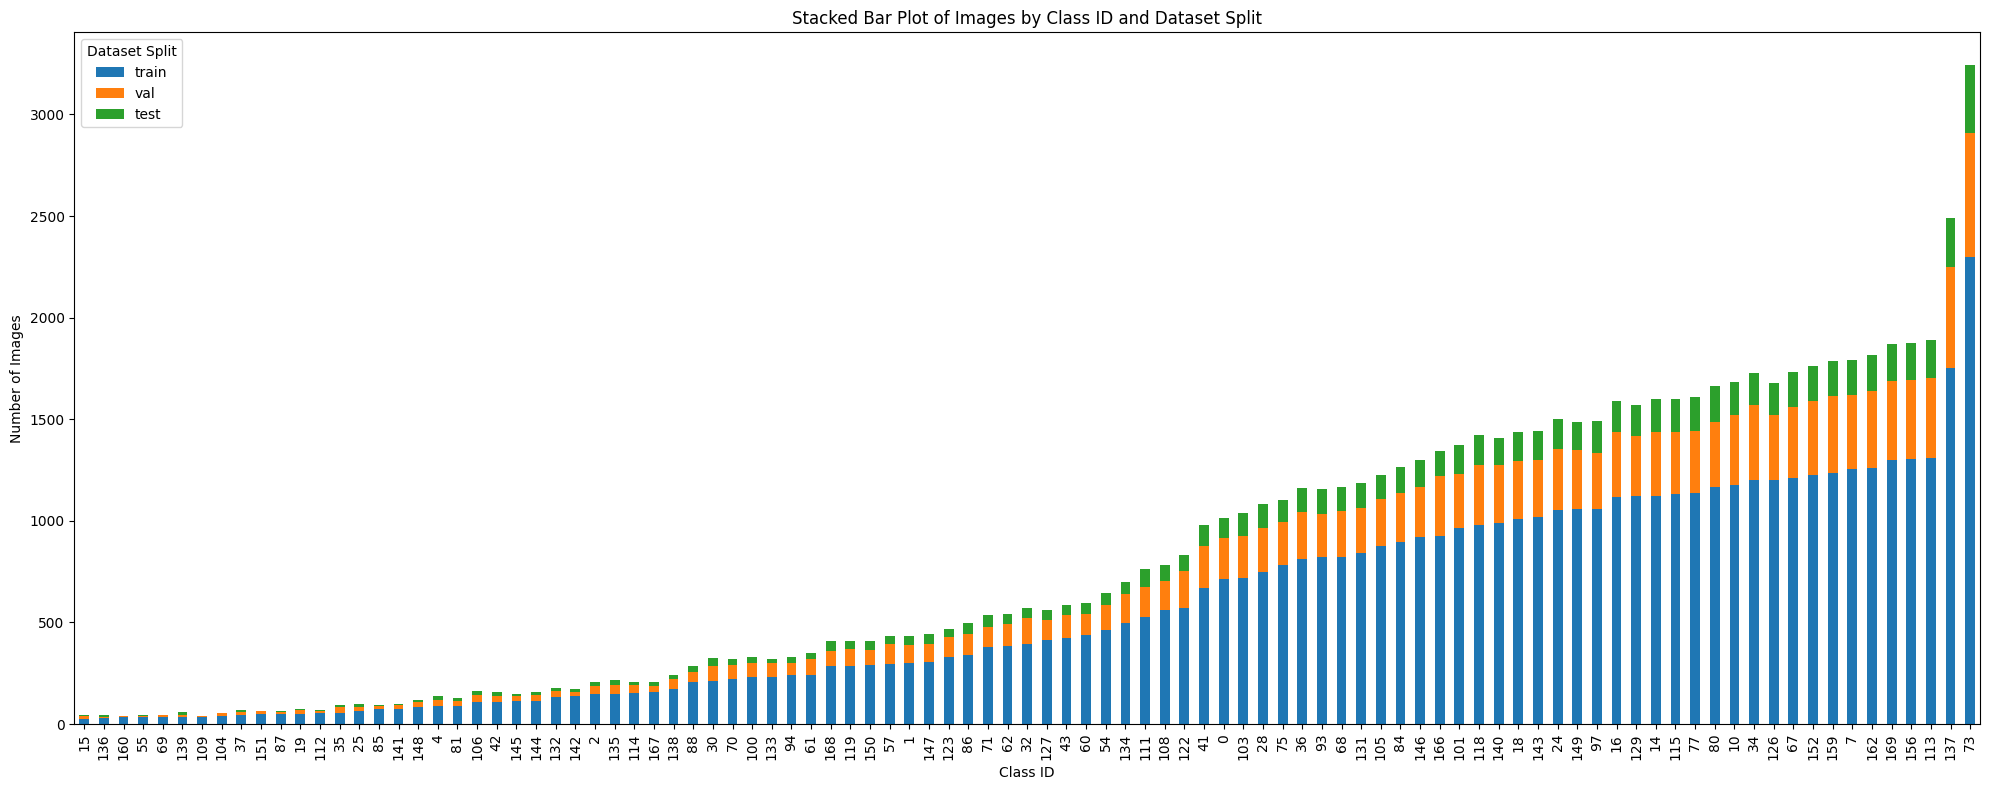

In [ ]:
df_pivot_P30 = df_investigate_split_P30.pivot_table(index='class_id', columns='set', values='# images')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_P30.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Stacked Bar Plot of Images by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

# P35

## investigate dataset

In [ ]:
len(investigate_all_P30_keep)

97

In [ ]:
df_investigate_all_P30_keep.sample(5)

class_id  # images  # instances
84         84      1263         2423
54         54       646          648
152       152      1761         5207
136       136        43           44
133       133       322          344

[ 21.   40.4  57.3  95.  148.8 208. ]
208.0


/tmp/ipython-input-91-571298076.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_investigate_all \


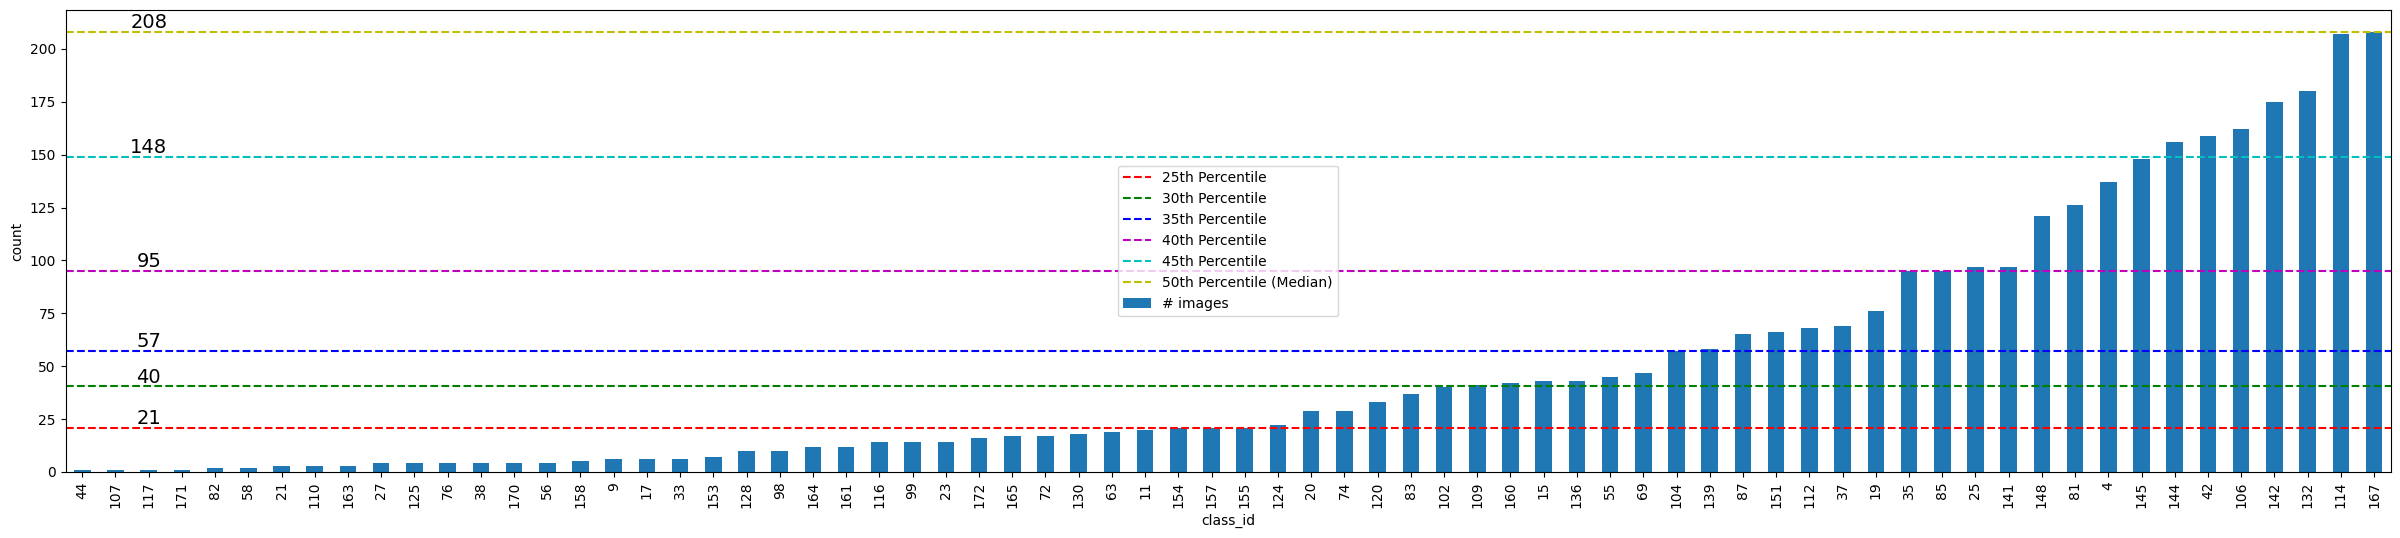

In [ ]:
percentiles = np.percentile(df_investigate_all['# images'], [25, 30, 35, 40, 45, 50])
print(percentiles)

df_investigate_all_median_image = df_investigate_all['# images'].median()
print(df_investigate_all_median_image)

df_investigate_all \
    .sort_values(by='# images')[df_investigate_all['# images'] <= df_investigate_all_median_image] \
    .plot.bar(y=['# images'], figsize=(30,6))
plt.axhline(y=percentiles[0], color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=percentiles[1], color='g', linestyle='--', label='30th Percentile')
plt.axhline(y=percentiles[2], color='b', linestyle='--', label='35th Percentile')
plt.axhline(y=percentiles[3], color='m', linestyle='--', label='40th Percentile')
plt.axhline(y=percentiles[4], color='c', linestyle='--', label='45th Percentile')
plt.axhline(y=percentiles[5], color='y', linestyle='--', label='50th Percentile (Median)')
plt.title('')
plt.legend()
for p in percentiles:
    plt.text(2, p, f'{int(p)}', va='bottom', ha='center', color='black', fontsize=14)
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

drop those below P35

In [ ]:
print(percentiles)
df_investigate_all_P35_drop = df_investigate_all_P30_keep[df_investigate_all_P30_keep['# images'] <= percentiles[2]]
print(df_investigate_all_P35_drop.index)
print(len(df_investigate_all_P35_drop.index))

[ 21.   40.4  57.3  95.  148.8 208. ]
Index([15, 55, 69, 104, 109, 136, 160], dtype='int64')
7


In [ ]:
df_investigate_all_P35_keep = df_investigate_all_P30_keep[df_investigate_all_P30_keep['# images'] > percentiles[2]]
print(df_investigate_all_P35_keep.index)
print(len(df_investigate_all_P35_keep.index))

Index([  0,   1,   2,   4,   7,  10,  14,  16,  18,  19,  24,  25,  28,  30,
        32,  34,  35,  36,  37,  41,  42,  43,  54,  57,  60,  61,  62,  67,
        68,  70,  71,  73,  75,  77,  80,  81,  84,  85,  86,  87,  88,  93,
        94,  97, 100, 101, 103, 105, 106, 108, 111, 112, 113, 114, 115, 118,
       119, 122, 123, 126, 127, 129, 131, 132, 133, 134, 135, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 156,
       159, 162, 166, 167, 168, 169],
      dtype='int64')
90


In [ ]:
investigate_all_P35_drop = {k: v for k, v in investigate_all_P30_keep.items() if k not in df_investigate_all_P35_keep.index}
len(investigate_all_P35_drop)

7

In [ ]:
investigate_all_P35_keep = {k: v for k, v in investigate_all_P30_keep.items() if k in df_investigate_all_P35_keep.index}
len(investigate_all_P35_keep)

90

## get class names

In [ ]:
class_ids_P35 = set(sorted(investigate_all_P35_keep.keys()))
print(len(class_ids_P35))

90


In [ ]:
class_names_P35 = [new_class_dict[str(id)] if id in class_ids_P35 else '' for id in range(list(class_ids_P35)[-1] + 1)]
print('Class names in order:', class_names_P35)
print(len(class_names_P35))

Class names in order: ['1.0', '1.1', '1.2', '', '1.7', '', '', '2.0', '', '', '3.0', '', '', '', '5.0', '', '6.0', '', '7.0', '7.1', '', '', '', '', '8.0', '8.3', '', '', '9.0', '', '9.4', '', '10.0', '', '11.0', '11.1', '13.0', '13.1', '', '', '', '14.0', '14.1', '14.2', '', '', '', '', '', '', '', '', '', '', '19.0', '', '', '19.3', '', '', '20.0', '20.1', '20.2', '', '', '', '', '23.0', '23.1', '', '24.0', '24.1', '', '26.0', '', '27.0', '', '28.0', '', '', '29.0', '29.1', '', '', '30.0', '30.1', '32.0', '32.1', '32.2', '', '', '', '', '35.0', '35.1', '', '', '37.0', '', '', '37.4', '38.0', '', '39.0', '', '40.0', '40.1', '', '41.0', '', '', '42.0', '42.1', '43.0', '43.1', '44.0', '', '', '45.0', '45.1', '', '', '46.0', '46.1', '', '', '47.0', '47.1', '', '48.0', '', '49.0', '49.3', '49.4', '50.0', '50.1', '', '51.0', '51.2', '51.3', '52.0', '52.3', '52.5', '53.0', '53.4', '53.5', '54.0', '54.4', '54.5', '55.0', '55.4', '55.5', '56.0', '', '', '', '57.0', '', '', '58.0', '', '', '59

In [ ]:
print(len([i for i in class_names_P35 if i != '']))

90


In [ ]:
with open(local_paths['class_names_P35'], 'w') as f:
    f.writelines([f'{name}\n' for name in class_names_P35])

## remove data

In [ ]:
if not Path(local_paths['label_id_backup_P35_dir']).exists():
    Path.mkdir(local_paths['label_id_backup_P35_dir'])

num_files_processed = process_label_files(
    label_dir=local_paths['image_label_dir'],
    backup_dir=local_paths['label_id_backup_P35_dir'],
    class_ids_to_remove=set(df_investigate_all_P35_drop.index)
)
print(num_files_processed)

Processed 2022_11_07_10_29_17-KTMP007320HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_15_56_20-HNIP288162HO.txt: 6 lines removed, original backed up
Processed 2022_11_07_08_37_34-HNIP454245HO.txt: 1 lines removed, original backed up
Processed 2023_01_18_16_22_12-SLAP012221HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_12_08_14-KTMP021152HO.txt: 1 lines removed, original backed up
Processed 2022_11_01_08_59_07-CBGP001148HO.txt: 1 lines removed, original backed up
Processed 2022_12_01_09_45_01-HDGP004122HO.txt: 2 lines removed, original backed up
Processed 2022_12_13_09_51_42-TNNP074133HO.txt: 1 lines removed, original backed up
Processed 2022_11_04_09_34_48-PYNP019090HO.txt: 1 lines removed, original backed up
Processed 2022_11_08_10_45_38-DNIP069297HO.txt: 1 lines removed, original backed up
Processed 2023_01_11_14_47_35-PTOP041250HO.txt: 1 lines removed, original backed up
Processed 2022_11_23_10_11_08-TBHP047075HO.txt: 1 lines removed, original ba

In [ ]:
all_images_P35 = sorted([Path(local_paths['image_label_dir'], f) for f in Path.iterdir(local_paths['image_label_dir']) if f.suffix == '.jpg'])
print(len(all_images_P35))
write_image_paths(all_images_P35, local_paths['all_paths_P35'])

10554


In [ ]:
_, empty_label_list_P35 = investigate_set(local_paths['all_paths_P35'], class_ids_P35)

In [ ]:
print(f'after removing labels, there are {len(empty_label_list_P35)} data with no labels')

after removing labels, there are 0 data with no labels


In [ ]:
if not Path(local_paths['empty_data_P35_dir']).exists():
    Path.mkdir(local_paths['empty_data_P35_dir'])
count = 0
for image_id in empty_label_list_P35:
    shutil.move(Path(local_paths['image_label_dir'], image_id).with_suffix('.jpg'), local_paths['empty_data_P35_dir'])
    shutil.move(Path(local_paths['image_label_dir'], image_id).with_suffix('.txt'), local_paths['empty_data_P35_dir'])
    count += 1
print(f'file moved: {count*2}')

file moved: 0


In [ ]:
all_images_P35 = sorted([Path(local_paths['image_label_dir'], f) for f in Path.iterdir(local_paths['image_label_dir']) if f.suffix == '.jpg'])
print(len(all_images_P35))
write_image_paths(all_images_P35, local_paths['all_paths_P35'])

10554


## Split dataset & save dataset division

In [ ]:
new_all_images_P35 = all_images_P35.copy()
train_images = []
val_images = []
test_images = []
for i in range(1000):
    for itrain in range(70):
        if len(new_all_images_P35) == 0:
            continue
        train_images.append(new_all_images_P35.pop(0))
    for ival in range(20):
        if len(new_all_images_P35) == 0:
            continue
        val_images.append(new_all_images_P35.pop(0))
    for itest in range(10):
        if len(new_all_images_P35) == 0:
            continue
        test_images.append(new_all_images_P35.pop(0))

In [ ]:
len(all_images_P35)

10554

In [ ]:
# train_ratio = 0.7
# val_ratio = 0.2
# test_ratio = 0.1

# # no shuffle!
# train_images, temp_images = train_test_split(all_images_P35, train_size=train_ratio, shuffle=False)
# val_images, test_images = train_test_split(temp_images, train_size=(val_ratio / (val_ratio + test_ratio)), shuffle=False)

In [ ]:
print(len(train_images))

7404


In [ ]:
write_image_paths(train_images, local_paths['train_paths_P35'])
write_image_paths(val_images, local_paths['val_paths_P35'])
write_image_paths(test_images, local_paths['test_paths_P35'])

In [ ]:
investigate_train_P35, _ = investigate_set(local_paths['train_paths_P35'], class_ids_P35)
investigate_val_P35, _ = investigate_set(local_paths['val_paths_P35'], class_ids_P35)
investigate_test_P35, _ = investigate_set(local_paths['test_paths_P35'], class_ids_P35)

In [ ]:
df_investigate_train_P35 = investigation_dict2df(investigate_train_P35)
df_investigate_val_P35 = investigation_dict2df(investigate_val_P35)
df_investigate_test_P35 = investigation_dict2df(investigate_test_P35)

90
90
90


In [ ]:
df_investigate_train_P35['set'] = 'train'
df_investigate_val_P35['set'] = 'val'
df_investigate_test_P35['set'] = 'test'

In [ ]:
df_investigate_split_P35 = pd.concat([df_investigate_train_P35, df_investigate_val_P35, df_investigate_test_P35], axis=0, ignore_index=True)
df_investigate_split_P35

class_id  # images  # instances    set
0           0       713          714  train
1           1       302          303  train
2           2       146          146  train
3           4        88           92  train
4           7      1256         1268  train
..        ...       ...          ...    ...
265       162       175          175   test
266       166       123          124   test
267       167        21           25   test
268       168        46           52   test
269       169       181          181   test

[270 rows x 4 columns]

In [ ]:
df_investigate_split_P35.to_csv('/content/split_P35.csv')

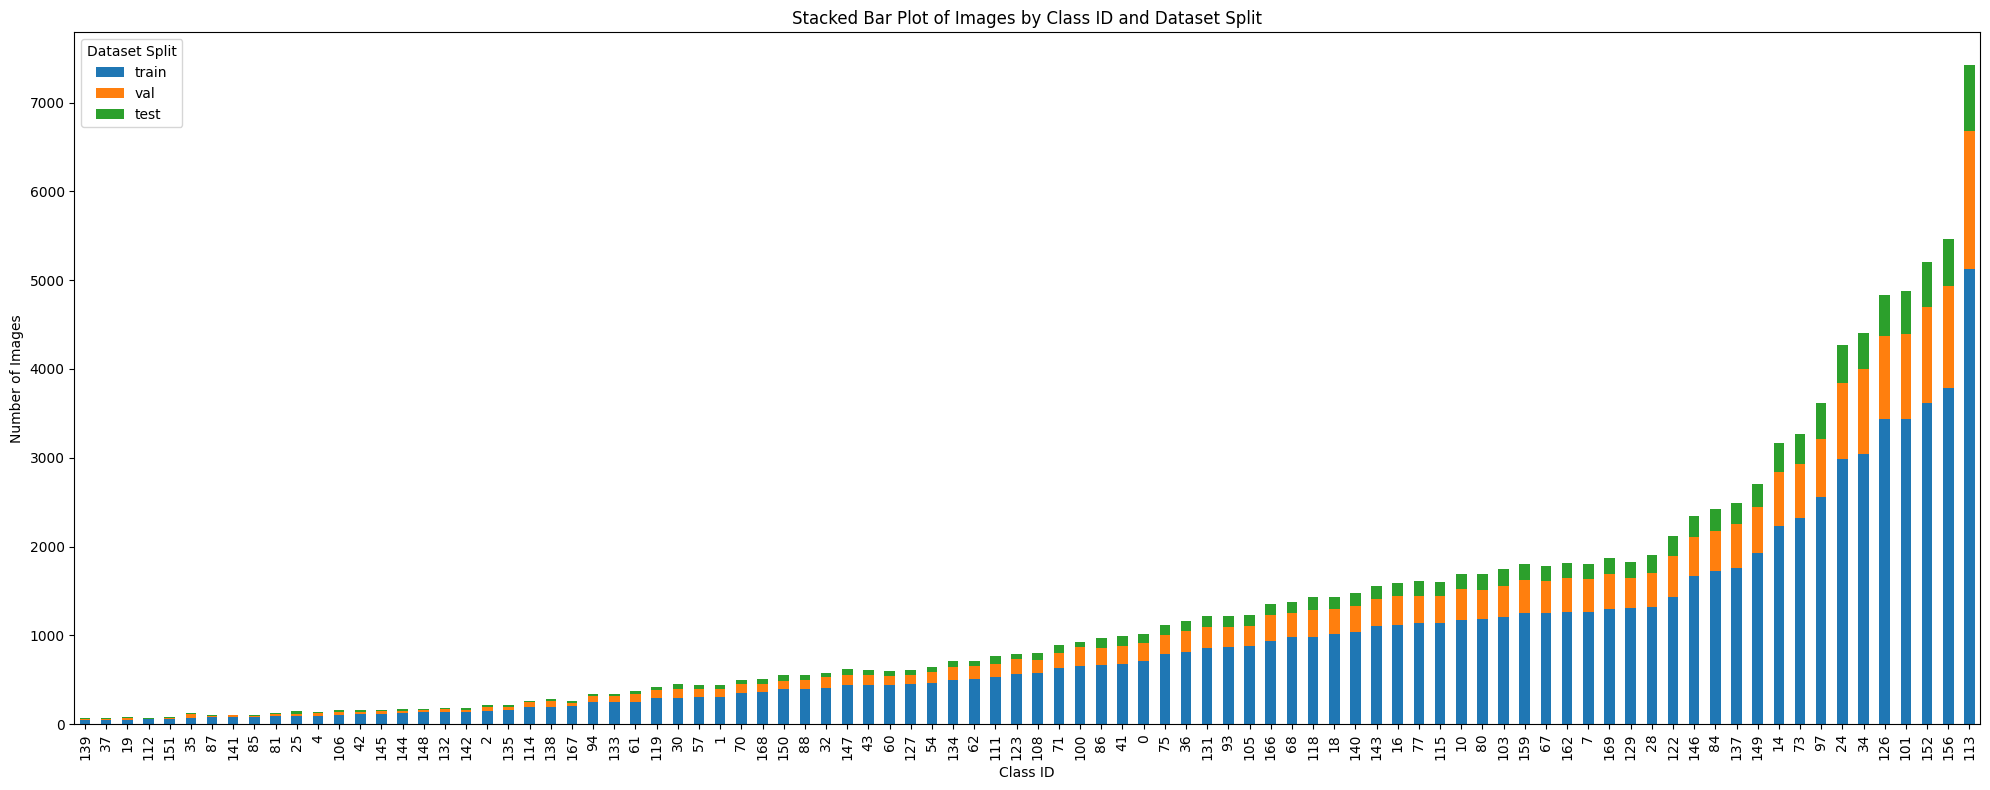

In [ ]:
df_pivot_P35 = df_investigate_split_P35.pivot_table(index='class_id', columns='set', values='# instances')[['train', 'val', 'test']]

# Create a stacked bar plot
df_pivot_P35.sort_values(by='train').plot(kind='bar', stacked=True, figsize=(20, 8))

plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Stacked Bar Plot of Images by Class ID and Dataset Split')
plt.legend(title='Dataset Split')
plt.tight_layout()

In [ ]:
df_pivot_P35.sort_values(by='train').head()

set       train   val  test
class_id                   
139        46.0  12.0  12.0
37         47.0  14.0   8.0
19         51.0  16.0   9.0
112        53.0   9.0   6.0
151        59.0  14.0   4.0

# learn custom class names todo

In [ ]:
new_class_dict

{'0': '1.0',
 '1': '1.1',
 '2': '1.2',
 '4': '1.7',
 '7': '2.0',
 '9': '2.3',
 '10': '3.0',
 '11': '3.1',
 '14': '5.0',
 '15': '5.1',
 '16': '6.0',
 '17': '6.1',
 '18': '7.0',
 '19': '7.1',
 '20': '7.2',
 '21': '7.3',
 '23': '7.7',
 '24': '8.0',
 '25': '8.3',
 '27': '8.5',
 '28': '9.0',
 '30': '9.4',
 '32': '10.0',
 '33': '10.1',
 '34': '11.0',
 '35': '11.1',
 '36': '13.0',
 '37': '13.1',
 '38': '13.2',
 '41': '14.0',
 '42': '14.1',
 '43': '14.2',
 '44': '14.3',
 '54': '19.0',
 '55': '19.1',
 '56': '19.2',
 '57': '19.3',
 '58': '19.4',
 '60': '20.0',
 '61': '20.1',
 '62': '20.2',
 '63': '20.3',
 '67': '23.0',
 '68': '23.1',
 '69': '23.2',
 '70': '24.0',
 '71': '24.1',
 '72': '24.3',
 '73': '26.0',
 '74': '26.1',
 '75': '27.0',
 '76': '27.1',
 '77': '28.0',
 '80': '29.0',
 '81': '29.1',
 '82': '29.2',
 '83': '29.4',
 '84': '30.0',
 '85': '30.1',
 '86': '32.0',
 '87': '32.1',
 '88': '32.2',
 '93': '35.0',
 '94': '35.1',
 '97': '37.0',
 '98': '37.1',
 '99': '37.3',
 '100': '37.4',
 '101':

In [ ]:
data = {
    'model_id': [i for i in range(173)],
    'class_id': [new_class_dict[str(i)] if str(i) in new_class_dict.keys() else None for i in range(173)],
    'name':     [matching_name_id[float(new_class_dict[str(i)])] if str(i) in new_class_dict.keys() else None for i in range(173)]
}

In [ ]:
df = pd.DataFrame(data=data)

In [ ]:
df.to_csv('/content/drive/MyDrive/fiber_optic_box_inspection/matching.csv', index=True, encoding='utf-8')

In [ ]:
new_class_dict.keys()

dict_keys(['0', '1', '2', '4', '7', '9', '10', '11', '14', '15', '16', '17', '18', '19', '20', '21', '23', '24', '25', '27', '28', '30', '32', '33', '34', '35', '36', '37', '38', '41', '42', '43', '44', '54', '55', '56', '57', '58', '60', '61', '62', '63', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '80', '81', '82', '83', '84', '85', '86', '87', '88', '93', '94', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172'])

In [ ]:
matching_name_id_df = pd.read_excel(paths['matching_name_id'], sheet_name=0)
matching_name_id = dict(zip(matching_name_id_df['Label ID'], matching_name_id_df['Tên Label']))
print(matching_name_id[1.0])

Tên tập điểm: sơn đỏ/đen(Đạt)


In [ ]:
matching_name_id

{1.0: 'Tên tập điểm: sơn đỏ/đen(Đạt)',
 1.1: 'Tên bị mờ',
 1.2: 'Giấy dán quảng cáo che',
 1.7: 'Sơn sai quy cách',
 2.0: 'Nắp tập điểm(Đạt)',
 2.1: 'Mất nắp tập điểm',
 2.3: 'Vỡ nắp tập điểm',
 3.0: 'Ốc khóa bán nguyệt(Đạt)',
 3.1: 'Mất ốc khóa bán nguyệt',
 4.0: 'Ốc vít khóa hộp(Đạt)',
 4.1: 'Mất ốc vít khóa hộp',
 5.0: 'Tai nhựa đóng/mở hộp (2 tai)(Đạt)',
 5.1: 'Vỡ tai nhựa đóng/mở hộp',
 6.0: 'Bản lề tập điểm(Đạt)',
 6.1: 'Vỡ bản lề tập điểm',
 7.0: 'Ống nhựa luồn cáp(Đạt)',
 7.1: 'Bắt cao/thấp so với đáy tập điểm',
 7.2: 'Không có ống nhựa luồn cáp',
 7.3: 'Ống nhựa luồn cáp đặt không đúng bên trái hộp',
 7.7: 'Vỡ ống nhựa luồn cáp',
 8.0: 'Đai inox(Đạt)',
 8.3: 'Đai inox đánh không chặt',
 8.5: 'Đai inox bị mất',
 9.0: 'Khóa đai inox(Đạt)',
 9.4: 'Khóa đai lắp không đúng vị trí theo quy định (lắp trên ống nhựa)',
 10.0: 'Khung đáy tập điểm(Đạt)',
 10.1: 'Khung đáy tập điểm vỡ',
 11.0: 'Gioăng cao su chống nước(Đạt)',
 11.1: 'Gioăng cao su chống nước bị mất',
 13.0: 'Cáp hạ tầng(Đ

In [ ]:
# id_to_names = matching_name_id_df.groupby(matching_name_id_df['Label ID'].astype(int))['Tên Label'].apply(list).to_dict()

# def find_names_by_id(integer_part):
#     return id_to_names.get(int(integer_part), ['ID not found'])

# integer_part = 0
# names = find_names_by_id(integer_part)
# print(f'Names for IDs with integer part {integer_part}: {names}')

In [ ]:
# id_to_names

# Prepare dataset configuration

### YOLO

In [81]:
yolo_data_cfg_P25 = {
    'train': str(local_paths['train_paths_P25']),
    'val': str(local_paths['val_paths_P25']),
    'test': str(local_paths['test_paths_P25']),
    'nc': len(class_names_P25),
    'names': class_names_P25
}

with open(local_paths['yolo_data_cfg_P25'], 'w') as f:
    yaml.dump(yolo_data_cfg_P25, f, default_flow_style=False, sort_keys=False)

In [ ]:
yolo_data_cfg_P30 = {
    'train': str(local_paths['train_paths_P30']),
    'val': str(local_paths['val_paths_P30']),
    'test': str(local_paths['test_paths_P30']),
    'nc': len(class_names_P30),
    'names': class_names_P30
}

with open(local_paths['yolo_data_cfg_P30'], 'w') as f:
    yaml.dump(yolo_data_cfg_P30, f, default_flow_style=False, sort_keys=False)

In [ ]:
yolo_data_cfg_P35 = {
    'train': str(local_paths['train_paths_P35']),
    'val': str(local_paths['val_paths_P35']),
    'test': str(local_paths['test_paths_P35']),
    'nc': len(class_names_P35),
    'names': class_names_P35
}

with open(local_paths['yolo_data_cfg_P35'], 'w') as f:
    yaml.dump(yolo_data_cfg_P35, f, default_flow_style=False, sort_keys=False)

### detectron2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-77xb04b6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-77xb04b6
  Resolved https://github.com/facebookresearch/detectron2.git to commit b15f64ec4429e23a148972175a0207c5a9ab84cf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6052896 sha256=24454a068c4102faca69470f02139a3806574b3ff94458fdd8079ea0d1e13607
  Stored in directory: /tmp/pip-ephem-wheel-cache-__t6aene/wheels/17/d9/40/60db98e485aa9455d

In [ ]:
import random

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [ ]:
def extract_data_from_image_label(image_id: Path):
    record = {}

    filename = str(image_id.with_suffix('.jpg'))
    image_height, image_width = cv2.imread(filename).shape[:2]

    record['file_name'] = filename
    record['image_id'] = image_id.stem
    record['height'] = image_height
    record['width'] = image_width

    objs = []

    with open(image_id.with_suffix('.txt'), 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split(' ')
        class_id = int(parts[0])
        (x_center, y_center, bbox_width, bbox_height) = map(float, parts[1:5])
        x_min_abs = max(0.0, x_center * image_width - (bbox_width/2) * image_width)
        y_min_abs = max(0.0, y_center * image_height - (bbox_height/2) * image_height)
        bbox_width_abs = bbox_width * image_width
        bbox_height_abs = bbox_height * image_height

        obj = {
            'bbox': [np.int64(round(x_min_abs)), np.int64(round(y_min_abs)), np.int64(round(bbox_width_abs)), np.int64(round(bbox_height_abs))],
            'bbox_mode': BoxMode.XYWH_ABS,
            'category_id': class_id,
        }
        objs.append(obj)

    record['annotations'] = objs
    return record


def get_data_from_subset(subset: Path):
    dataset_dicts = []
    with open(subset, 'r') as f:
        image_ids = [Path(line.strip()) for line in f.readlines()]

    with Pool() as pool:
        results = pool.map(extract_data_from_image_label, image_ids)

    dataset_dicts.extend(results)
    return dataset_dicts

In [ ]:
DatasetCatalog

DatasetCatalog(registered datasets: fiber_optic_train, fiber_optic_val, fiber_optic_test, fiber_optic_train_1_crop)

In [ ]:
DatasetCatalog.clear()
MetadataCatalog.clear()
for d in [
    local_paths['train_paths'],
    local_paths['val_paths'],
    local_paths['test_paths'],
    local_paths['train_paths_crop']
]:
    DatasetCatalog.register('fiber_optic_' + d.stem, lambda d=d: get_data_from_subset(d))
    MetadataCatalog.get('fiber_optic_' + d.stem).set(thing_classes=read_class_names())

namespace(name='fiber_optic',
          thing_classes=['1.0',
                         '1.1',
                         '1.2',
                         '',
                         '1.7',
                         '',
                         '',
                         '2.0',
                         '',
                         '2.3',
                         '3.0',
                         '3.1',
                         '',
                         '',
                         '5.0',
                         '5.1',
                         '6.0',
                         '6.1',
                         '7.0',
                         '7.1',
                         '7.2',
                         '7.3',
                         '',
                         '7.7',
                         '8.0',
                         '8.3',
                         '',
                         '8.5',
                         '9.0',
                         '',
                         '9.4',
     

In [ ]:
fiber_optic_metadata = MetadataCatalog.get('fiber_optic')

In [ ]:
train_dicts = get_data_from_subset(local_paths['train_paths'])
val_dicts = get_data_from_subset(local_paths['val_paths'])
train_1_crop_dicts = get_data_from_subset(local_paths['train_paths_crop'])

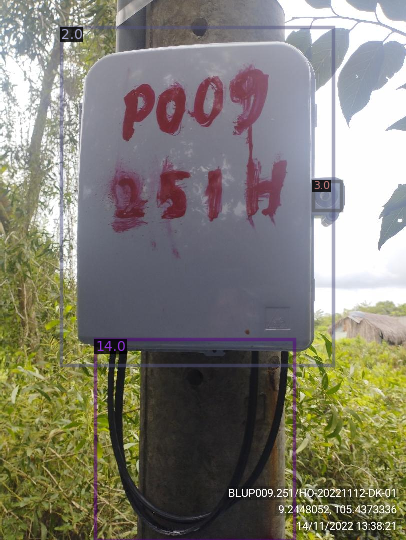

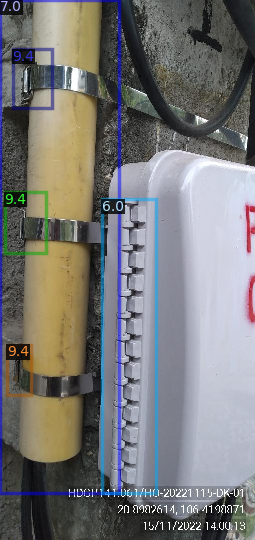

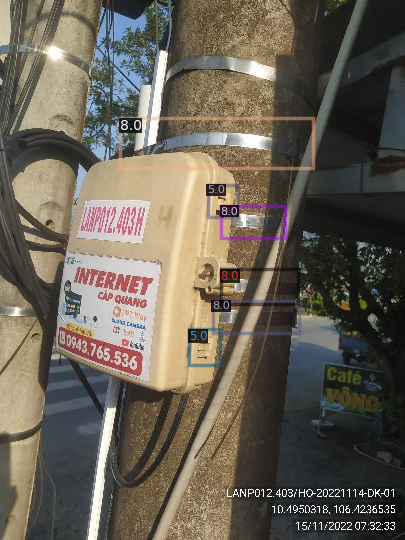

In [ ]:
for d in random.sample(train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fiber_optic_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

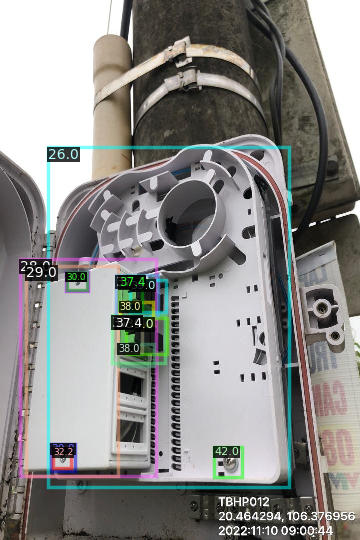

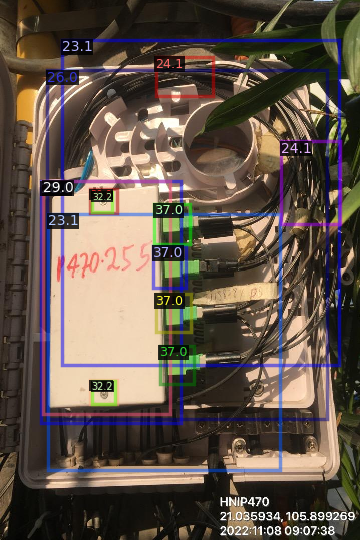

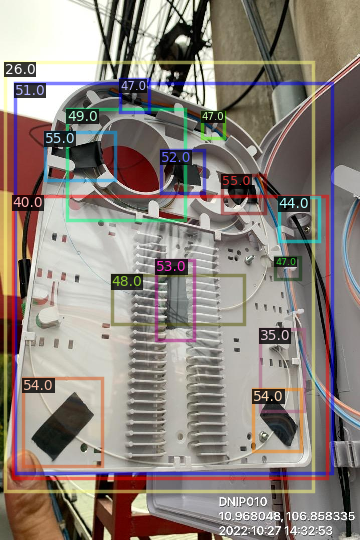

In [ ]:
for d in random.sample(train_1_crop_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fiber_optic_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Backup processed files and configurations

In [71]:
!rm -rf {local_paths['processed_dataset_compressed']}
!rm -rf {paths['dataset_dir']}

In [72]:
def compress_folders_to_tar_gz(folders, output_tar_gz):
    try:
        with tarfile.open(output_tar_gz, 'w:gz') as tar:
            for folder in folders:
                if not folder.is_dir():
                    print(f'Error: {folder} is not a directory or does not exist.')
                    continue
                tar.add(folder, arcname=folder.name)
                print(f'Added folder: {folder}')
        print(f'Created archive: {output_tar_gz}')
        return True
    except Exception as e:
        print(f'Error creating archive: {e}')
        return False

In [73]:
compress_folders_to_tar_gz(
    [
        local_paths['empty_data_dir'],
        local_paths['empty_data_P25_dir'],
        local_paths['empty_data_P30_dir'],
        local_paths['empty_data_P35_dir'],
        local_paths['image_label_dir'],
        local_paths['label_bbox_backup_dir'],
        local_paths['label_id_backup_dir'],
        local_paths['label_id_backup_P25_dir'],
        local_paths['label_id_backup_P30_dir'],
        local_paths['label_id_backup_P35_dir'],
        local_paths['image_label_P35_dir_crop'],
    ],
    local_paths['processed_dataset_compressed']
)

Added folder: /content/dataset_v2_ALL/empty_data
Added folder: /content/dataset_v2_ALL/empty_data_P25
Error: /content/dataset_v2_ALL/empty_data_P30 is not a directory or does not exist.
Error: /content/dataset_v2_ALL/empty_data_P35 is not a directory or does not exist.
Added folder: /content/dataset_v2_ALL/image_label
Added folder: /content/dataset_v2_ALL/label_bbox_backup
Added folder: /content/dataset_v2_ALL/label_id_backup
Added folder: /content/dataset_v2_ALL/label_id_backup_P25
Error: /content/dataset_v2_ALL/label_id_backup_P30 is not a directory or does not exist.
Error: /content/dataset_v2_ALL/label_id_backup_P35 is not a directory or does not exist.
Error: /content/dataset_v2_ALL/image_label_P35_1_crop is not a directory or does not exist.
Created archive: /content/dataset_v2_ALL/processed_dataset.tar.gz


True

In [74]:
def copy_folder_exclude(src_dir, dst_dir, exclude_entries=None):
    if exclude_entries is None:
        exclude_entries = set()

    try:
        def ignore_func(directory, contents):
            return [entry for entry in contents if entry in exclude_entries]

        shutil.copytree(src_dir, dst_dir, ignore=ignore_func, dirs_exist_ok=True)
        print(f'Folder copied to: {dst_dir}')
        return True
    except FileNotFoundError:
        print(f'Error: Source directory {src_dir} not found.')
        return False
    except FileExistsError:
        print(f'Error: Destination directory {dst_dir} already exists and cannot be overwritten.')
        return False
    except Exception as e:
        print(f'Error copying folder: {e}')
        return False

In [75]:
paths['dataset_dir']

PosixPath('/content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL')

In [76]:
exclude = {
        local_paths['empty_data_dir'].stem,
        local_paths['empty_data_P25_dir'].stem,
        local_paths['empty_data_P30_dir'].stem,
        local_paths['empty_data_P35_dir'].stem,
        local_paths['image_label_dir'].stem,
        local_paths['label_bbox_backup_dir'].stem,
        local_paths['label_id_backup_dir'].stem,
        local_paths['label_id_backup_P25_dir'].stem,
        local_paths['label_id_backup_P30_dir'].stem,
        local_paths['label_id_backup_P35_dir'].stem,
        local_paths['image_label_P35_dir_crop'].stem,
}
copy_folder_exclude(local_paths['dataset_dir'], paths['dataset_dir'], exclude)

Folder copied to: /content/drive/MyDrive/fiber_optic_box_inspection/dataset_v2_ALL


True

In [77]:
print(Path(local_paths['processed_dataset_compressed']).stat().st_size == Path(paths['processed_dataset_compressed']).stat().st_size)

True


# Augmentation

## augmentation utils

In [ ]:
def extract_data_from_label(label_path):
    class_labels, bboxes = [], []
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        (class_id, x_center, y_center, width, height) = line.strip().split(' ')
        class_labels.append(int(class_id))
        bboxes.append([float(x_center), float(y_center), float(width), float(height)])
    return np.array(class_labels), np.array(bboxes, dtype=np.float32)

In [ ]:
def transform_image(args):
    image_id, transform_pipeline = args
    image = cv2.imread(image_id.with_suffix('.jpg'))

    class_labels, bboxes = extract_data_from_label(image_id.with_suffix('.txt'))

    augmented = transform_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)

    new_image_id = Path(local_paths['image_label_P35_dir_crop'], image_id.stem)
    new_image_path = new_image_id.with_suffix('.jpg')
    new_label_path = new_image_id.with_suffix('.txt')

    cv2.imwrite(new_image_path, augmented['image'])
    with open(new_label_path, 'w') as f:
        for bbox, label in zip(augmented['bboxes'], augmented['class_labels']):
            f.write(f'{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')
def transform_images(ids, transform_pipeline):
    agrs = [(id, transform_pipeline) for id in ids]
    with Pool() as pool:
        results = pool.map(transform_image, agrs)
    print(results)

In [ ]:
def visualize(image_id: Path, augmented_dir: Path):
    image = cv2.imread(image_id.with_suffix('.jpg'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    class_labels, bboxes = extract_data_from_label(image_id.with_suffix('.txt'))

    image_stem = image_id.stem
    augmented_ids = set(sorted(
        [augmented.with_suffix('') for augmented in augmented_dir.glob(f'**/{image_stem}.*') if augmented.with_suffix('') != image_id]
    ))
    print(augmented_ids)

    figure, ax = plt.subplots(1, len(augmented_ids) + 1, figsize=(30, 10))
    if len(augmented_ids) == 0:
        ax = [ax]

    # Draw original
    original_drawn = draw_bboxes(image, bboxes, class_labels)
    ax[0].imshow(original_drawn)
    ax[0].set_title('Original')
    ax[0].axis('off')

    for idx, augmented_id in enumerate(augmented_ids):
        aug_image = cv2.imread(augmented_id.with_suffix('.jpg'))
        aug_image = cv2.cvtColor(aug_image, cv2.COLOR_BGR2RGB)
        aug_class_labels, aug_bboxes = extract_data_from_label(augmented_id.with_suffix('.txt'))

        augmented_drawn = draw_bboxes(aug_image, aug_bboxes, aug_class_labels)
        # cv2_imshow(augmented_drawn)
        ax[idx+1].imshow(augmented_drawn)
        ax[idx+1].set_title(augmented_id.parent.stem.replace(f'{image_id.parent.stem}_', ''))
        ax[idx+1].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def draw_bboxes(image_np, bboxes, labels, class_name_map=None, color=(0, 255, 0), thickness=2):
    img_res = image_np.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    h, w, _ = img_res.shape

    if not isinstance(bboxes, np.ndarray):
        print(f'Warning: bboxes is not an ndarray: {type(bboxes)}')
        return img_res
    if not isinstance(labels, np.ndarray):
        print(f'Warning: labels is not an ndarray: {type(labels)}')
        # Attempt to proceed if labels seem usable, otherwise return
        if len(bboxes) != len(labels):
            print('Warning: bbox and label length mismatch, cannot draw labels.')
            labels = np.array(['?' for _ in bboxes]) # Placeholder
        elif labels.dtype == object:
             print('Warning: labels contain object dtype, converting to string.')
             labels = labels.astype(str)

    for bbox, label in zip(bboxes, labels):
        # Assuming bbox format allows direct conversion to int x_min, y_min, x_max, y_max
        # This might need adjustment based on the ACTUAL format in your bboxes list
        # Example for pascal_voc or albumentations (after denormalizing)
        try:
             # Check if bbox has at least 4 elements
            if len(bbox) < 4:
                print(f'Warning: Skipping invalid bbox (fewer than 4 coords): {bbox}')
                continue
            x_center, y_center, width, height = map(float, bbox[:4])
            x_min, y_min, x_max, y_max = (x_center - width/2)*w, (y_center - height/2)*h, (x_center + width/2)*w, (y_center + height/2)*h
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        except (ValueError, TypeError) as e:
            print(f'Warning: Could not convert bbox coords to int: {bbox}, Error: {e}')
            continue # Skip this bbox

        cv2.rectangle(img_res, (x_min, y_min), (x_max, y_max), color, thickness)

        label_name = str(label) if class_name_map is None else class_name_map.get(label, str(label))
        # Simple text placement above the box
        (text_width, text_height), baseline = cv2.getTextSize(label_name, font, font_scale, font_thickness)
        text_y = y_min - baseline if y_min - baseline > text_height else y_min + text_height
        cv2.putText(img_res, label_name, (x_min, text_y), font, font_scale, color, font_thickness)

    return img_res

## Stage 1 - Crop

In [ ]:
IMGSZ

960

In [ ]:
transform_pipeline_1_crop = A.Compose([
    A.RandomSizedBBoxSafeCrop(height=IMGSZ, width=IMGSZ, p=1.0), #crop
], bbox_params=A.BboxParams(format='yolo',
                            label_fields=['class_labels']
                            ))

In [ ]:
train_images = read_image_paths(local_paths['train_paths_P35'])
train_images

[PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_13_04-DNIP003387HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_21_15-DNIP003390HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_27_49-DNIP003388HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_43_51-DNIP003391HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_55_59-DNIP003392HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_56_45-DNIP003392HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_41_55-DNIP003390HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_42_39-DNIP003390HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_42_59-DNIP003390HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_25_10_50_14-CMUP001172HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_25_10_59_32-CMUP001172HO.jpg'),
 PosixPath('/content/dataset_v2_

In [ ]:
print(len(train_images))

7404


In [ ]:
train_ids = [image.with_suffix('') for image in train_images]
train_ids

[PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_13_04-DNIP003387HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_21_15-DNIP003390HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_27_49-DNIP003388HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_43_51-DNIP003391HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_55_59-DNIP003392HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_14_56_45-DNIP003392HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_41_55-DNIP003390HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_42_39-DNIP003390HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_24_15_42_59-DNIP003390HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_25_10_50_14-CMUP001172HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_25_10_59_32-CMUP001172HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_25_14_57_26-DNIP0105

In [ ]:
print(len(train_ids))

7404


In [ ]:
crop_ids, _ = train_test_split(train_ids, train_size=0.5, random_state=42)
crop_ids

[PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_09_00_07-CMUP016035HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_17_10_08-HNIP584195HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_10_33_45-HDGP103082HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_18_15_32_37-HGGP020074HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_12_01_09_22_07-QNHP035348HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_12_05_10_53_13-QNHP044105HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_07_12_16_24-HNIP015351HU'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_17_16_20_53-HPGP016410HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_12_02_09_38_29-CBGP005219HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_15_09_21_28-HNIP163093HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_10_12_00_51-BGGP078118HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_12_09_11_06_54-HDGP0041

In [ ]:
print(len(crop_ids))

3702


In [ ]:
!rm -rf {local_paths['image_label_P35_dir_crop']}

In [ ]:
if not local_paths['image_label_P35_dir_crop'].exists():
    Path.mkdir(local_paths['image_label_P35_dir_crop'])

In [ ]:
transform_images(crop_ids, transform_pipeline_1_crop)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

[10  7  1 37] [[0.845679   0.45694444 0.0962963  0.06203704]
 [0.46187365 0.5129902  0.9237473  0.6982026 ]
 [0.47530866 0.32037038 0.4        0.22222222]
 [0.47066087 0.9194717  0.8469136  0.16105664]]


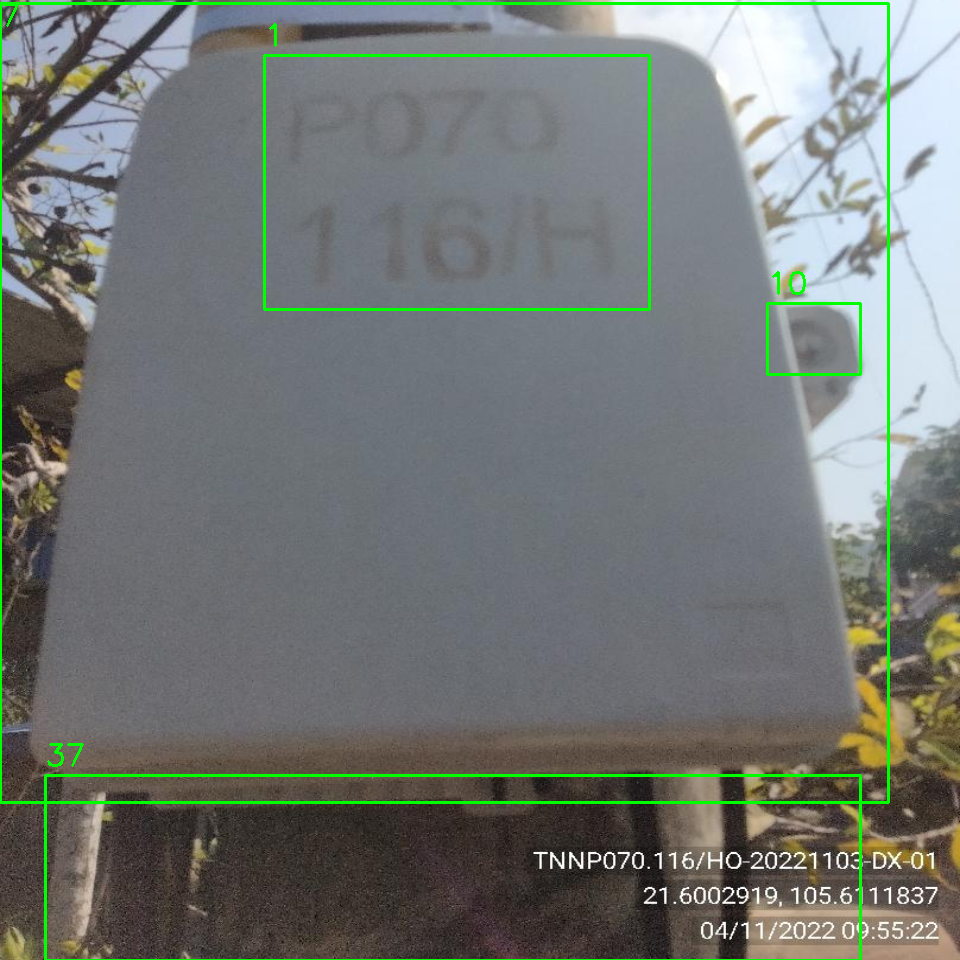

In [ ]:
class_labels, bboxes = extract_data_from_label('/content/dataset_v2_ALL/image_label/2022_11_04_09_55_36-TNNP070116HO.txt')
print(class_labels, bboxes)
image = cv2.imread('/content/dataset_v2_ALL/image_label/2022_11_04_09_55_36-TNNP070116HO.jpg')
augmented_img = transform_pipeline_1_crop(image=image, bboxes=bboxes, class_labels=class_labels)
cv2_imshow(draw_bboxes(image_np=augmented_img['image'], bboxes=augmented_img['bboxes'], labels=augmented_img['class_labels']))
del image, class_labels, bboxes, augmented_img

In [ ]:
# class_labels, bboxes = extract_data_from_label('/content/dataset_v2_ALL/image_label_P35_1_crop/2022_11_04_09_55_36-TNNP070116HO.txt')
# print(class_labels, bboxes)
# image = cv2.imread('/content/dataset_v2_ALL/image_label_P35_1_crop/2022_11_04_09_55_36-TNNP070116HO.jpg')
# # augmented_img = transform_pipeline_1_crop(image=image, bboxes=bboxes, class_labels=class_labels)
# # cv2_imshow(draw_bboxes(image_np=augmented_img['image'], bboxes=augmented_img['bboxes'], labels=augmented_img['class_labels']))
# cv2_imshow(draw_bboxes(image_np=image, bboxes=bboxes, labels=class_labels))
# del image, class_labels, bboxes
# # del augmented_img

In [ ]:
# visualize(crop_ids[0], local_paths['image_label_P35_dir_crop'])

In [ ]:
crop_images = [Path(local_paths['image_label_P35_dir_crop'], f) for f in Path.iterdir(local_paths['image_label_P35_dir_crop']) if f.suffix == '.jpg']
stage_1_images = []
stage_1_images.extend(train_images)
stage_1_images.extend(crop_images)
write_image_paths(stage_1_images, local_paths['train_paths_P35_crop'])

In [ ]:
print(len(train_images)+len(crop_images)==len(stage_1_images), len(stage_1_images))

True 11106


In [ ]:
class_names_P35 = read_class_names(local_paths['class_names_P35'])

In [ ]:
print(len([name for name in class_names_P35 if name != '']))

90


In [ ]:
yolo_data_cfg_1_crop = {
    'train': str(local_paths['train_paths_P35_crop']),
    'val': str(local_paths['val_paths_P35']),
    'test': str(local_paths['test_paths_P35']),
    'nc': len(class_names_P35),
    'names': class_names_P35
}

with open(local_paths['yolo_data_cfg_P35_crop'], 'w') as f:
    yaml.dump(yolo_data_cfg_1_crop, f, default_flow_style=False, sort_keys=False)

In [ ]:
with open('/content/dataset_v2_ALL/train_P35_1_crop.txt', 'r') as f:
    lines = f.readlines()
count = 0
for line in [line.strip() for line in lines]:
    if not Path(line).exists():
        print(line)
        count += 1
print(count)

0


## Stage 2 - Crop

In [ ]:
transform_pipeline_1_crop = A.Compose([
    A.RandomSizedBBoxSafeCrop(height=IMGSZ, width=IMGSZ, p=1.0), #crop
], bbox_params=A.BboxParams(format='yolo',
                            label_fields=['class_labels']
                            ))

In [ ]:
train_images = read_image_paths(local_paths['train_paths'])
train_images

[PosixPath('/content/dataset_v2_ALL/image_label/2022_11_03_14_39_17-GLIP025203HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_23_11_27_32-TBHP047071HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_15_37_32-HNIP454226HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_16_02_12-HNIP525306HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_02_15_49_09-BRUP002175HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_09_15_15-TNHP036173HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_19_13_04_29-DTPP007234HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_29_11_06_40-HPGP061409HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_13_02_12-BLUP009250HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_15_11_10_58-GLIP042107HO.jpg'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_06_23_16-HNIP660157HO.jpg'),
 PosixPath('/content/dataset_v2_

In [ ]:
train_ids = [image.with_suffix('') for image in train_images]
train_ids

[PosixPath('/content/dataset_v2_ALL/image_label/2022_11_03_14_39_17-GLIP025203HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_23_11_27_32-TBHP047071HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_15_37_32-HNIP454226HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_16_02_12-HNIP525306HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_02_15_49_09-BRUP002175HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_08_09_15_15-TNHP036173HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_19_13_04_29-DTPP007234HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_29_11_06_40-HPGP061409HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_13_02_12-BLUP009250HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_15_11_10_58-GLIP042107HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_06_23_16-HNIP660157HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_16_15_55_16-LANP0291

In [ ]:
crop_ids, _ = train_test_split(train_ids, train_size=0.5, random_state=42)
crop_ids

[PosixPath('/content/dataset_v2_ALL/image_label/2022_11_10_15_57_18-HNIP386073HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_11_11_07_51-DNIP109300HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_19_16_20_33-TGGP031228HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_11_09_24_23-HNIP622027HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_07_11_47_39-STGP019253HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_07_10_12_00-KTMP007351HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_29_09_08_54-NBHP013141HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_12_08_19_40-TBHP020132HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_14_11_12_28-HDGP141026HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_10_29_14_45_27-QNMP001137HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_11_04_15_47_24-QNIP028099HO'),
 PosixPath('/content/dataset_v2_ALL/image_label/2022_12_10_10_56_50-THAP0842

In [ ]:
!rm -rf /content/dataset_v2_ALL/image_label_1_crop

In [ ]:
if not local_paths['image_label_P35_dir_crop'].exists():
    Path.mkdir(local_paths['image_label_P35_dir_crop'])

In [ ]:
transform_images(crop_ids, transform_pipeline_1_crop)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

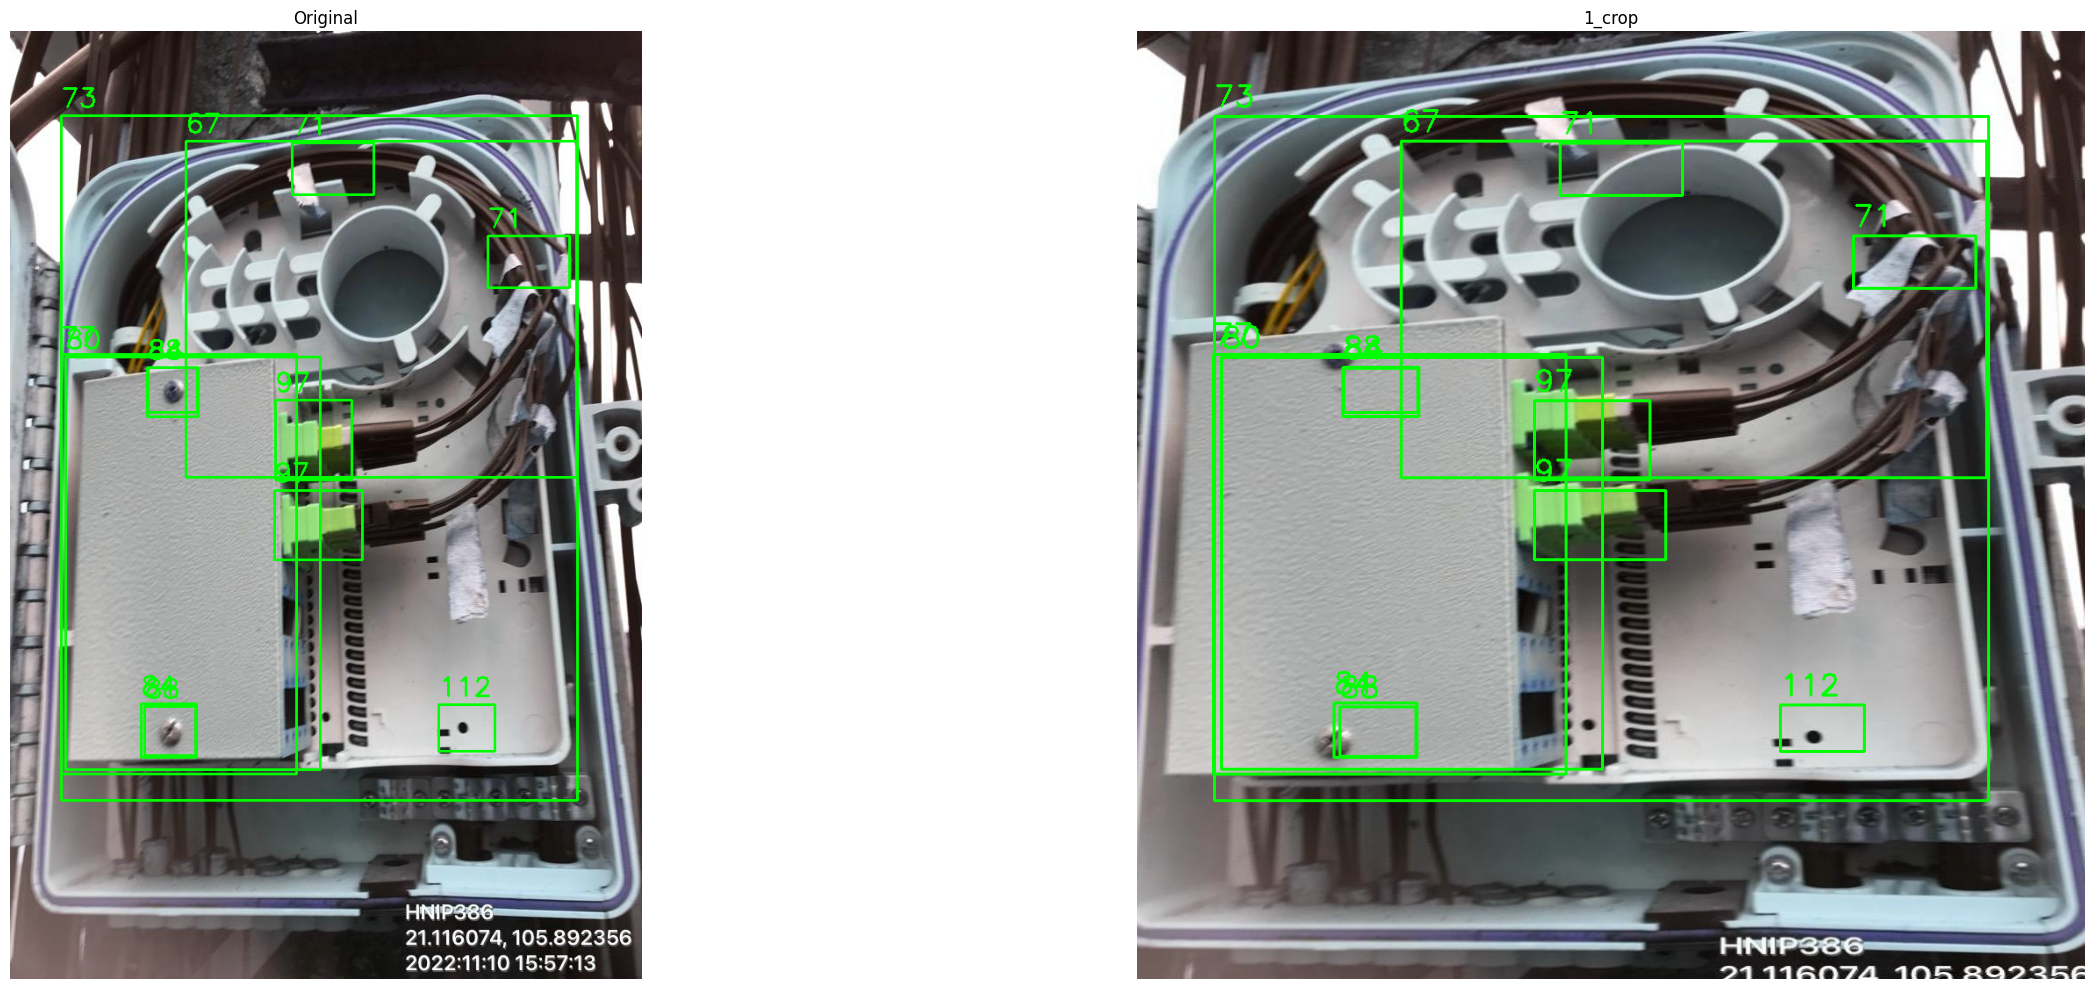

In [ ]:
visualize(crop_ids[0], local_paths['dataset_dir'])

In [ ]:
crop_images = [Path(local_paths['image_label_P35_dir_crop'], f) for f in Path.iterdir(local_paths['image_label_P35_dir_crop']) if f.suffix == '.jpg']
stage_1_images = []
stage_1_images.extend(train_images)
stage_1_images.extend(crop_images)
write_image_paths(stage_1_images, local_paths['train_paths_P35_crop'])

In [ ]:
yolo_data_cfg_1_crop = {
    'train': str(local_paths['train_paths_P35_crop']),
    'val': str(local_paths['val_paths']),
    'test': str(local_paths['test_paths']),
    'nc': len(class_names),
    'names': class_names
}

with open(local_paths['yolo_data_cfg_P35_crop'], 'w') as f:
    yaml.dump(yolo_data_cfg_1_crop, f, default_flow_style=False, sort_keys=False)